# Ground Zero

## Packages and Datasets

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'researchpy', 'missingno', 'folium', 'fancyimpute', 'pdpbox', 'dtreeviz.trees', 'graphviz'}
missing = required - installedPackages
if missing:
    !pip install researchpy
    !pip install missingno
    !pip install folium
    !pip install fancyimpute
    !pip install pdpbox
    !pip install dtreeviz
    !pip install graphviz

In [2]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.stats as ss

import folium
from folium import plugins

from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [4]:
# File Directories
path_crashes = '../crashes.sample2020.csv'
path_vehicles = '../vehicles.sample.csv'
path_people = '../people.sample.csv'

# Import samples
crashes = pd.read_csv(
    path_crashes,
    parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
    low_memory=False,
    dtype=object)

vehicles = pd.read_csv(path_vehicles,
                       parse_dates=["CRASH_DATE"],
                       low_memory=False,
                       dtype=object)

people = pd.read_csv(path_people,
                     parse_dates=["CRASH_DATE"],
                     low_memory=False,
                     dtype=object)

## Overview of Sprint 2
- Understanding of Feature Processes
- Data Merge & Split
- Feature Reduction & Missing Value Treatment
- Outliers
- Feature Engineering
- Baseline Model

## Our Understanding

### Feature Engineering Process

[Source](https://en.wikipedia.org/wiki/Feature_engineering)

The feature engineering process is:
- Brainstorming or testing features;
- Deciding what features to create;
- Creating features;
- Checking how the features work with your model;
- **Improving your features if needed;**
- Go back to brainstorming/creating more features until the work is done.

### Some Terms

[Source](https://datascience.stackexchange.com/questions/29006/feature-selection-vs-feature-extraction-which-to-use-when)

**Feature Extraction and Feature Engineering:** transformation of raw data into features suitable for modeling; 

- Texts(ngrams, word2vec, tf-idf etc)
- Geospatial data(lat, long)
- Date and time(day, month, week, year, rolling based)
- Time series, web, etc
- Dimensional Reduction Techniques (PCA, SVD, Eigen-Faces etc)
- Clustering (DBSCAN etc)
- And others.

---

**Feature / Data Transformation:** transformation of data to improve the accuracy of the algorithm;
- Normalization and changing distribution(Scaling)
- Interactions
- Handling missing Values
- Handling outliers
- Handling time-date / mixed variables
- Encoding categorical features
- Variable types 
- And others.

---

**Feature Selection:** removing unnecessary features.

- Statistical approaches
- Selection by modeling
- Grid search
- Cross Validation
- And others

---

For the purpose of workflow, we will split **Feature Selection** into; 
- **feature reduction** to remove unnecessary features, 
- and **feature selection** to select features by their importance scores through ML/statistical techniques.

# Data Merge & Split

## Merging datasets

The goal is to successfully merge all datasets by increasing crash records as little as possible.

In [5]:
print("Here is the initial shape of the three datasets:")
print("Crashes", crashes.shape)
print("Vehicles", vehicles.shape)
print("People", people.shape)

Here is the initial shape of the three datasets:
Crashes (33408, 49)
Vehicles (75673, 72)
People (82049, 30)


**Data Merge Strategy**

- Filter out passengers from **`people`**, and left-join it to **`vehicles`** on `CRASH_RECORD_ID`, `RD_NO`, `CRASH_DATE`, `VEHICLE_ID`.

- Then inner-join this dataset to **`crashes`** on `CRASH_RECORD_ID`, `RD_NO`, `CRASH_DATE`.

---

**Reasoning**

- `people` has **many-to-one relationship** with `vehicles` but a pedestrian in `vehicles` has **one-to-one** with `people`,

- Passengers don't have <u>a trajectory separate from the unit</u> they belong to and they don't contribute to accidents with their existence but they are involved if they got harmed through `injuries` features,

- This method increases `crashes` records **only per active parties involved**.

In [6]:
# Filter only non-pessenger people (drivers, pedestrian, cyclist, etc.)
non_passengers = people[people.PERSON_ID.str.contains('^O')]

In [7]:
# Left join non-peseenger people with vehicles
vehicles_with_people = vehicles.merge(non_passengers, 
                                      how='left', 
                                      on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE', 'VEHICLE_ID'])
vehicles_with_people.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,RD_NO,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,228894,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,1,DRIVER,NaN,224185,NaN,DODGE,CHARGER,IL,2012,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,Y,NaN,1,NaN,PRIVATE TOW,UNKNOWN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O228894,DRIVER,NaN,KANKAKKE,IL,60901,M,18,IL,D,SAFETY BELT USED,"DEPLOYED, FRONT",NONE,NONINCAPACITATING INJURY,NaN,NaN,NaN,UNKNOWN,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,228895,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,2,PARKED,NaN,224187,NaN,GENERAL MOTORS CORP.,YUKON,IL,2003,UNKNOWN,PASSENGER,PERSONAL,N,PARKED,Y,NaN,0,NaN,PRIVATE TOW,UNKNOWN,N,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,228896,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,3,PARKED,NaN,224191,NaN,SATURN,UNKNOWN,IL,2000,UNKNOWN,PASSENGER,PERSONAL,N,PARKED,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-RIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,228905,f7210aec9ac43a7b36c30b49033adebcb3060b96580341...,JA453640,2017-10-01 02:41:00,1,DRIVER,NaN,224199,NaN,FORD,WINDSTAR,IL,2007,NONE,VAN/MINI-VAN,PERSONAL,E,STRAIGHT AHEAD,Y,NaN,1,NaN,NaN,NaN,NaN,Y,Y,Y,Y,NaN,N,N,N,NaN,NaN,Y,NaN,NaN,TOTAL (ALL AREAS),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O228905,DRIVER,NaN,CHICAGO,IL,60632,M,43,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,IMPROPER LANE CHANGE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,228906,f7210aec9ac43a7b36c30b49033adebcb3060b96580341...,JA453640,2017-10-01 02:41:00,2,DRIVERLESS,NaN,224203,NaN,CHEVROLET,CRUZE,IL,2012,NONE,PASSENGER,NOT IN USE,UNKNOWN,PARKED,Y,NaN,0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,Y,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Shape of vehicles with people", vehicles_with_people.shape)

Shape of vehicles with people (75838, 98)


In [9]:
merged_data = crashes.merge(vehicles_with_people, 
                            how='inner', 
                            on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE'])

print('Dimensions of the data after merging', merged_data.shape)

Dimensions of the data after merging (68503, 144)


**Inspection 1**

In [10]:
merged_data.groupby('CRASH_RECORD_ID').head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_UNIT_ID,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667550,1,DRIVER,NaN,635502,NaN,CHEVROLET,EQUINOX,IL,2017,UNKNOWN,SPORT UTILITY VEHICLE (SUV),UNKNOWN/NA,W,STRAIGHT AHEAD,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667550,DRIVER,NaN,HOMEWOOD,IL,60430,F,56,IL,D,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667551,2,DRIVER,1,635496,NaN,CHEVROLET,SILVERADO,IL,2016,NONE,PICKUP,PERSONAL,W,STARTING IN TRAFFIC,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667551,DRIVER,NaN,PALOS HILLS,IL,60465,M,51,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST 

**Inspection 2**

In [11]:
print("Wrong joins could have resulted in 6 rows. Here we see 2 rows, meaning the join was successful.")
merged_data[merged_data.RD_NO.eq('JC301403')] #Wrong joins could result in 6 rows

Wrong joins could have resulted in 6 rows. Here we see 2 rows, meaning the join was successful.


,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_UNIT_ID,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667550,1,DRIVER,NaN,635502,NaN,CHEVROLET,EQUINOX,IL,2017,UNKNOWN,SPORT UTILITY VEHICLE (SUV),UNKNOWN/NA,W,STRAIGHT AHEAD,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667550,DRIVER,NaN,HOMEWOOD,IL,60430,F,56,IL,D,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667551,2,DRIVER,1,635496,NaN,CHEVROLET,SILVERADO,IL,2016,NONE,PICKUP,PERSONAL,W,STARTING IN TRAFFIC,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667551,DRIVER,NaN,PALOS HILLS,IL,60465,M,51,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST 

## Splitting the data

In [12]:
# Alternative: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
raw_train, raw_test = train_test_split(merged_data, test_size=0.20, random_state=42, shuffle=True)

In [13]:
print("Train shape", raw_train.shape)
print("Test shape", raw_test.shape)

Train shape (54802, 144)
Test shape (13701, 144)


**Write datasets as csv**

In [14]:
# save the train and test file
#train.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_train.csv')
#test.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_test.csv')

# Feature Reduction

## Detailed look at all features

In [15]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54802 entries, 29244 to 15795
Columns: 144 entries, CRASH_RECORD_ID to CELL_PHONE_USE
dtypes: datetime64[ns](2), object(142)
memory usage: 60.6+ MB


| **Feature** | **Description** | **Decision to drop** |
|:-----|:----:|----:|
| CRASH_RECORD_ID | This number can be used to link to the same crash in the Vehicles and People datasets. This number also serves as a unique ID in this dataset. | NO |
| RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes. | YES |
| CRASH_DATE_EST_I | Crash date estimated by desk officer or reporting party (only used in cases where crash is reported at police station days after the crash) | YES |
| CRASH_DATE | Date and time of crash as entered by the reporting officer | NO |
| POSTED_SPEED_LIMIT | Posted speed limit, as determined by reporting officer | NO |
| TRAFFIC_CONTROL_DEVICE | Traffic control device present at crash location, as determined by reporting officer | NO |
| DEVICE_CONDITION | Condition of traffic control device, as determined by reporting officer | NO |
| WEATHER_CONDITION | Weather condition at time of crash, as determined by reporting officer | NO |
| LIGHTING_CONDITION | Light condition at time of crash, as determined by reporting officer | NO |
| FIRST_CRASH_TYPE | Type of first collision in crash | NO |
| TRAFFICWAY_TYPE | Trafficway type, as determined by reporting officer | NO |
| LANE_CNT | Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection) | NO |
| ALIGNMENT | Street alignment at crash location, as determined by reporting officer | YES |
| ROADWAY_SURFACE_COND | Road surface condition, as determined by reporting officer | NO |
| ROAD_DEFECT | Road defects, as determined by reporting officer | NO |
| REPORT_TYPE | Administrative report type (at scene, at desk, amended) | YES |
| CRASH_TYPE | A general severity classification for the crash. Can be either Injury and/or Tow Due to Crash or No Injury / Drive Away | YES |
| INTERSECTION_RELATED_I |A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection. | NO |
| NOT_RIGHT_OF_WAY_I | Whether the crash begun or first contact was made outside of the public right-of-way. | YES |
| HIT_AND_RUN_I | Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid | NO |
| DAMAGE | A field observation of estimated damage. | NO |
| DATE_POLICE_NOTIFIED | Calendar date on which police were notified of the crash | YES |
| PRIM_CONTRIBUTORY_CAUSE | The factor which was most significant in causing the crash, as determined by officer judgment | NO |
| SEC_CONTRIBUTORY_CAUSE | The factor which was second most significant in causing the crash, as determined by officer judgment | NO |
| STREET_NO | Street address number of crash location, as determined by reporting officer | NO |
| STREET_DIRECTION | Street address direction (N,E,S,W) of crash location, as determined by reporting officer | YES |
| STREET_NAME | Street address name of crash location, as determined by reporting officer | NO |
| BEAT_OF_OCCURRENCE | Chicago Police Department Beat ID | YES |
| PHOTOS_TAKEN_I | Whether the Chicago Police Department took photos at the location of the crash | YES |
| STATEMENTS_TAKEN_I | Whether statements were taken from unit(s) involved in crash | YES |
| DOORING_I | Whether crash involved a motor vehicle occupant opening a door into the travel path of a bicyclist, causing a crash | YES |
| WORK_ZONE_I | Whether the crash occurred in an active work zone | YES |
| WORK_ZONE_TYPE | The type of work zone, if any | YES |
| WORKERS_PRESENT_I | Whether construction workers were present in an active work zone at crash location | YES |
| NUM_UNITS | Number of units involved in the crash. A unit can be a motor vehicle, a pedestrian, a bicyclist, or another non-passenger roadway user. Each unit represents a mode of traffic with an independent trajectory. | NO |
| MOST_SEVERE_INJURY | Most severe injury sustained by any person involved in the crash | NO |
| INJURIES_TOTAL | Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer | NO |
| INJURIES_FATAL | Total persons sustaining fatal injuries in the crash | NO |
| INJURIES_INCAPACITATING | Total persons sustaining incapacitating/serious injuries in the crash as determined by the reporting officer. Any injury other than fatal injury, which prevents the injured person from walking, driving, or normally continuing the activities they were capable of performing before the injury occurred. Includes severe lacerations, broken limbs, skull or chest injuries, and abdominal injuries. | NO |
| INJURIES_NON_INCAPACITATING | Total persons sustaining non-incapacitating injuries in the crash as determined by the reporting officer. Any injury, other than fatal or incapacitating injury, which is evident to observers at the scene of the crash. Includes lump on head, abrasions, bruises, and minor lacerations. | NO |
| INJURIES_REPORTED_NOT_EVIDENT | Total persons sustaining possible injuries in the crash as determined by the reporting officer. Includes momentary unconsciousness, claims of injuries not evident, limping, complaint of pain, nausea, and hysteria. | NO |
| INJURIES_NO_INDICATION | Total persons sustaining no injuries in the crash as determined by the reporting officer | YES |
| INJURIES_UNKNOWN | Total persons for whom injuries sustained, if any, are unknown | YES |
| CRASH_HOUR | The hour of the day component of CRASH_DATE. | NO |
| CRASH_DAY_OF_WEEK | The day of the week component of CRASH_DATE. Sunday=1 | YES |
| CRASH_MONTH | The month component of CRASH_DATE. | YES |
| LATITUDE | The latitude of the crash location, as determined by reporting officer, as derived from the reported address of crash | YES |
| LONGITUDE | The longitude of the crash location, as determined by reporting officer, as derived from the reported address of crash | YES |
| LOCATION | The crash location, as determined by reporting officer, as derived from the reported address of crash, in a column type that allows for mapping and other geographic analysis in the data portal software | NO || PERSON_ID | A unique identifier for each person record. IDs starting with P indicate passengers. IDs starting with O indicate a person who was not a passenger in the vehicle (e.g., driver, pedestrian, cyclist, etc.). | NO |
| PERSON_TYPE | Type of roadway user involved in crash | NO |
| CRASH_RECORD_ID | This number can be used to link to the same crash in the Crashes and Vehicles datasets. This number also serves as a unique ID in the Crashes dataset. | NO |
| RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes. | YES |
| VEHICLE_ID | The corresponding CRASH_UNIT_ID from the Vehicles dataset. | YES |
| CRASH_DATE | Date and time of crash as entered by the reporting officer | YES |
| SEAT_NO | Code for seating position of motor vehicle occupant: 1= driver, 2= center front, 3 = front passenger, 4 = second row left, 5 = second row center, 6 = second row right, 7 = enclosed passengers, 8 = exposed passengers, 9= unknown position, 10 = third row left, 11 = third row center, 12 = third row right | YES |
| CITY | City of residence of person involved in crash | YES |
| STATE | State of residence of person involved in crash | YES |
| ZIPCODE | ZIP Code of residence of person involved in crash | YES |
| SEX | Gender of person involved in crash, as determined by reporting officer | NO |
| AGE | Age of person involved in crash | NO |
| DRIVERS_LICENSE_STATE | State issuing driver's license of person involved in crash | YES |
| DRIVERS_LICENSE_CLASS| Class of driver's license of person involved in crash | YES |
| SAFETY_EQUIPMENT | Safety equipment used by vehicle occupant in crash, if any | NO |
| AIRBAG_DEPLOYED | Whether vehicle occupant airbag deployed as result of crash | NO |
| EJECTION | Whether vehicle occupant was ejected or extricated from the vehicle as a result of crash | NO |
| INJURY_CLASSIFICATION | Severity of injury person sustained in the crash | YES |
| HOSPITAL | Hospital to which person injured in the crash was taken | YES |
| EMS_AGENCY | EMS agency who transported person injured in crash to the hospital | YES |
| EMS_RUN_NO | EMS agency run number | YES |
| DRIVER_ACTION | Driver action that contributed to the crash, as determined by reporting officer | NO |
| DRIVER_VISION | What, if any, objects obscured the driver’s vision at time of crash | NO |
| PHYSICAL_CONDITION | Driver’s apparent physical condition at time of crash, as observed by the reporting officer | NO |
| PEDPEDAL_ACTION | Action of pedestrian or cyclist at the time of crash | YES |
| PEDPEDAL_VISIBILITY | Visibility of pedestrian of cyclist safety equipment in use at time of crash | YES |
| PEDPEDAL_LOCATION | Location of pedestrian or cyclist at the time of crash | YES |
| BAC_RESULT | Status of blood alcohol concentration testing for driver or other person involved in crash | YES |
| BAC_RESULT VALUE | Driver’s blood alcohol concentration test result | YES |
| CELL_PHONE_USE | Whether person was/was not using cellphone at the time of the crash, as determined by the reporting officer | NO |
|CRASH_UNIT_ID | A unique identifier for each vehicle record | YES | 
|CRASH_RECORD_ID | This number can be used to link to the same crash in the Crashes and People datasets. This number also serves as a unique ID in the Crashes dataset | NO | 
|RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes | Yes | 
|CRASH_DATE| Date and time of crash as entered by the reporting officer | No | 
|UNIT_NO| A unique ID for each unit within a specific crash report | Yes | 
|UNIT_TYPE| Type of unit | Yes | 
|NUM_PASSENGERS| Number of passengers in the vehicle. The driver is not included. More information on passengers is in the People dataset | No | 
|VEHICLE_ID| No definition | Yes | 
|CMRC_VEH_I| No definition | Yes | 
|MAKE| The make (brand) of the vehicle, if relevant | Yes | 
|MODEL| The model of the vehicle, if relevant| Yes | 
|LIC_PLATE_STATE| The state issuing the license plate of the vehicle, if relevant | No | 
|VEHICLE_YEAR| The model year of the vehicle, if relevant | No | 
|VEHICLE_DEFECT| No definition | No | 
|VEHICLE_TYPE| The type of vehicle, if relevant | No | 
|TRAVEL_DIRECTION| The direction in which the unit was traveling prior to the crash, as determined by the reporting officer | No | 
|MANEUVER| The action the unit was taking prior to the crash, as determined by the reporting officer | NO | 
|TOWED_I| Indicator of whether the vehicle was towed | Yes | 
|FIRE_I| No definition | Yes | 
|OCCUPANT_COUNT| The number of people in the unit, as determined by the reporting officer | No | 
|EXCEED_SPEED_LIMIT_I| Indicator of whether the unit was speeding, as determined by the reporting officer | No | 
|TOWED_BY| No definition | Yes | 
|TOWED_TO| No definition | Yes | 
|AREA_00_I:AREA_99_I| No definition | Yes | 
|FIRST_CONTACT_POINT| No definition | No | 
|CMV_ID:HAZMAT_CLASS| No definition | Yes |


**Features to be excluded are**
- `RD_NO`
- `CRASH_DATE_EST_I`
- `REPORT_TYPE`
- `CRASH_DATE_EST_I`
- `REPORT_TYPE`
- `CRASH_TYPE`
- `NOT_RIGHT_OF_WAY_I`
- `DATE_POLICE_NOTIFIED`
- `STREET_DIRECTION`
- `ALIGNMENT`
- `BEAT_OF_OCCURRENCE`
- `PHOTOS_TAKEN_I`
- `STATEMENTS_TAKEN_I`
- `DOORING_I`
- `WORK_ZONE_I`
- `WORK_ZONE_TYPE`
- `WORKERS_PRESENT_I`
- `MOST_SEVERE_INJURY`
- `INJURIES_NO_INDICATION`
- `INJURIES_UNKNOWN`
- `CRASH_DAY_OF_WEEK`
- `CRASH_MONTH`
- `LATITUDE`
- `LONGITUDE`
- `RD_NO`
- `VEHICLE_ID`
- `CRASH_DATE`
- `SEAT_NO`
- `CITY`
- `STATE`
- `ZIPCODE`
- `DRIVERS_LICENSE_STATE`
- `DRIVERS_LICENSE_CLASS`
- `INJURY_CLASSIFICATION`
- `HOSPITAL`
- `EMS_AGENCY`
- `EMS_RUN_NO`
- `PEDPEDAL_ACTION`	
- `PEDPEDAL_VISIBILITY`
- `PEDPEDAL_LOCATION`
- `BAC_RESULT`
- `BAC_RESULT VALUE`
- `CRASH_UNIT_ID`
- `RD_NO`
- `UNIT_NO`
- `UNIT_TYPE`
- `VEHICLE_ID`
- `CMRC_VEH_I`
- `MAKE`
- `MODEL`
- `TOWED_I`
- `FIRE_I`
- `TOWED_BY`
- `TOWED_TO`
- `AREA_00_I`
- `AREA_01_I`
- `AREA_02_I`
- `AREA_03_I`
- `AREA_04_I`
- `AREA_05_I`
- `AREA_06_I`
- `AREA_07_I`
- `AREA_08_I`
- `AREA_09_I`
- `AREA_10_I`
- `AREA_11_I`
- `AREA_12_I`
- `AREA_99_I`
- `CMV_ID:HAZMAT_CLASS`




**Due to the reasons**
- Redundant information
- Non value information (at least for our baseline model)

In [16]:
# Drop the features that are not needed
feature_drop_train = ["CRASH_DATE_EST_I", "REPORT_TYPE", "CRASH_DATE_EST_I", "REPORT_TYPE", 
                      "NOT_RIGHT_OF_WAY_I", "DATE_POLICE_NOTIFIED", "STREET_DIRECTION",
                      "ALIGNMENT", "BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", 
                      "DOORING_I", "WORK_ZONE_I", "WORK_ZONE_TYPE", "WORKERS_PRESENT_I", 
                      "INJURIES_NO_INDICATION", "INJURIES_UNKNOWN", 
                      "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "LATITUDE", "LONGITUDE", "RD_NO", "VEHICLE_ID", 
                      "CRASH_DATE", "SEAT_NO", "CITY", "STATE", "ZIPCODE", "DRIVERS_LICENSE_STATE", 
                      "DRIVERS_LICENSE_CLASS", "INJURY_CLASSIFICATION", "HOSPITAL", "EMS_AGENCY", 
                      "EMS_RUN_NO", "PEDPEDAL_ACTION", "PEDPEDAL_VISIBILITY", "PEDPEDAL_LOCATION", 
                      "BAC_RESULT", "CRASH_UNIT_ID", "RD_NO", "UNIT_NO", "UNIT_TYPE", "VEHICLE_ID", 
                      "CMRC_VEH_I", "MAKE", "MODEL", "TOWED_I", "FIRE_I", "TOWED_BY", 
                      "TOWED_TO", "AREA_00_I", "AREA_01_I", "AREA_02_I", "AREA_03_I", "AREA_04_I", 
                      "AREA_05_I", "AREA_06_I", "AREA_07_I", "AREA_08_I", "AREA_09_I", "AREA_10_I", 
                      "AREA_11_I", "AREA_12_I", "AREA_99_I", "CMV_ID", "USDOT_NO", "CCMC_NO", 
                      "ILCC_NO", "COMMERCIAL_SRC", "GVWR", "CARRIER_NAME", "CARRIER_STATE", "CARRIER_CITY",
                      "HAZMAT_PLACARDS_I", "HAZMAT_NAME", "UN_NO", "HAZMAT_PRESENT_I", "HAZMAT_REPORT_I",
                      "HAZMAT_REPORT_NO", "MCS_REPORT_I", "MCS_REPORT_NO", "HAZMAT_VIO_CAUSE_CRASH_I", 
                      "MCS_VIO_CAUSE_CRASH_I", "IDOT_PERMIT_NO", "WIDE_LOAD_I", "TRAILER1_WIDTH", 
                      "TRAILER2_WIDTH", "TRAILER1_LENGTH", "TRAILER2_LENGTH", "TOTAL_VEHICLE_LENGTH",
                      "AXLE_CNT", "VEHICLE_CONFIG", "CARGO_BODY_TYPE", "LOAD_TYPE", "HAZMAT_OUT_OF_SERVICE_I",
                      "MCS_OUT_OF_SERVICE_I", "HAZMAT_CLASS", "BAC_RESULT VALUE"]

train = raw_train.loc[:, ~raw_train.columns.isin(feature_drop_train)]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54802 entries, 29244 to 15795
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   CRASH_RECORD_ID                54802 non-null  object
 1   POSTED_SPEED_LIMIT             54802 non-null  object
 2   TRAFFIC_CONTROL_DEVICE         54802 non-null  object
 3   DEVICE_CONDITION               54802 non-null  object
 4   WEATHER_CONDITION              54802 non-null  object
 5   LIGHTING_CONDITION             54802 non-null  object
 6   FIRST_CRASH_TYPE               54802 non-null  object
 7   TRAFFICWAY_TYPE                54802 non-null  object
 8   LANE_CNT                       18076 non-null  object
 9   ROADWAY_SURFACE_COND           54802 non-null  object
 10  ROAD_DEFECT                    54802 non-null  object
 11  CRASH_TYPE                     54802 non-null  object
 12  INTERSECTION_RELATED_I         13322 non-null  object
 1

## Missing value overview on train data

In [17]:
print('\033[1m', 'All 50 columns', '\033[0m')
print('\033[1m', 'These', sum(train.isnull().mean().round(5) > 0.5),
      'columns have > 50% missing values', '\033[0m')
print(train.columns[train.isnull().mean().round(5) > 0.5].tolist())
print('')
raw_null_above50 = train[train.columns[train.isnull().mean().round(5) > 0.5].tolist()]
print(raw_null_above50.isnull().mean().round(5))
print('')
# Subset the data to include the columns only with nulls in the output
train_with_null = train[train.columns[train.isnull().any()].tolist()]
print('\033[1m', 'These', len(train_with_null.columns),
      'columns have any missing values', '\033[0m')
train_with_null.isnull().mean().round(5)

 All 50 columns 
 These 6 columns have > 50% missing values 
['LANE_CNT', 'INTERSECTION_RELATED_I', 'HIT_AND_RUN_I', 'NUM_PASSENGERS', 'EXCEED_SPEED_LIMIT_I', 'CELL_PHONE_USE']

LANE_CNT                  0.67016
INTERSECTION_RELATED_I    0.75691
HIT_AND_RUN_I             0.70238
NUM_PASSENGERS            0.84501
EXCEED_SPEED_LIMIT_I      0.99715
CELL_PHONE_USE            0.99896
dtype: float64

 These 32 columns have any missing values 


LANE_CNT                         0.67016
INTERSECTION_RELATED_I           0.75691
HIT_AND_RUN_I                    0.70238
MOST_SEVERE_INJURY               0.00210
INJURIES_TOTAL                   0.00208
INJURIES_FATAL                   0.00208
INJURIES_INCAPACITATING          0.00208
INJURIES_NON_INCAPACITATING      0.00208
INJURIES_REPORTED_NOT_EVIDENT    0.00208
LOCATION                         0.00553
NUM_PASSENGERS                   0.84501
LIC_PLATE_STATE                  0.10591
VEHICLE_YEAR                     0.18196
VEHICLE_DEFECT                   0.02688
VEHICLE_TYPE                     0.02688
VEHICLE_USE                      0.02688
TRAVEL_DIRECTION                 0.02688
MANEUVER                         0.02688
OCCUPANT_CNT                     0.02688
EXCEED_SPEED_LIMIT_I             0.99715
FIRST_CONTACT_POINT              0.03465
PERSON_ID                        0.13861
PERSON_TYPE                      0.13861
SEX                              0.13943
AGE             

| **Feature** | **Description** | **Decision on NA** |
|:----|:----|:-----|
| LANE_CNT | Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection) | Replace with mode = 2 |
| INTERSECTION_RELATED_I | A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection.Y&N | Replace with "N" |
| HIT_AND_RUN_I |  Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid Y&N | Replace with "N" |
| INJURIES_TOTAL | Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer | Replace with "0" |
| INJURIES_FATAL | Total persons sustaining fatal injuries in the crash | Replace with "0" |
| INJURIES_INCAPACITATING | Total persons sustaining incapacitating/serious injuries in the crash as determined by the reporting officer. Any injury other than fatal injury, which prevents the injured person from walking, driving, or normally continuing the activities they were capable of performing before the injury occurred. Includes severe lacerations, broken limbs, skull or chest injuries, and abdominal injuries. | Replace with "0" |
| INJURIES_NON_INCAPACITATING | Total persons sustaining no injuries in the crash as determined by the reporting officer | Replace with "0" |
| INJURIES_REPORTED_NOT_EVIDENT | Total persons sustaining possible injuries in the crash as determined by the reporting officer. Includes momentary unconsciousness, claims of injuries not evident, limping, complaint of pain, nausea, and hysteria. | Replace with "0" |
| LOCATION | The crash location, as determined by reporting officer, as derived from the reported address of crash, in a column type that allows for mapping and other geographic analysis in the data portal software | DROP the row |
| NUM_PASSENGERS | Number of passengers in the vehicle. The driver is not included. More information on passengers is in the People dataset. | DROP the column |
| LIC_PLATE_STATE | The state issuing the license plate of the vehicle, if relevant | Replace with "IL" |
| VEHICLE_YEAR | The model year of the vehicle, if relevant | DROP the row |
| VEHICLE_DEFECT | no definition | Replace with "UNKNOWN" |
| VEHICLE_TYPE | The type of vehicle, if relevant | Replace with "UNKNOWN/NA" |
| VEHICLE_USE | The normal use of the vehicle, if relevant | Replace with "UNKNOWN/NA" |
| TRAVEL_DIRECTION | The direction in which the unit was traveling prior to the crash, as determined by the reporting officer | Replace with "UNKNOWN" |
| MANEUVER | The action the unit was taking prior to the crash, as determined by the reporting officer | Replace with "UNKNOWN/NA" |
| OCCUPANT_CNT |The number of people in the unit, as determined by the reporting officer | DROP the row |
| EXCEED_SPEED_LIMIT_I | Indicator of whether the unit was speeding, as determined by the reporting officer | DROP Column |
| FIRST_CONTACT_POINT | No definition | Replace with "UNKNOWN" |
| PERSON_ID | A unique identifier for each person record. IDs starting with P indicate passengers. IDs starting with O indicate a person who was not a passenger in the vehicle (e.g., driver, pedestrian, cyclist, etc.). | DROP the row |
| PERSON_TYPE | Type of roadway user involved in crash | DROP the row |
| SEX | Gender of person involved in crash, as determined by reporting officer | Replace with "X" |
| AGE | Age of person involved in crash | Replace with mean |
| SAFETY_EQUIPMENT | Safety equipment used by vehicle occupant in crash, if any | Replace with "USAGE UNKNOWN" |
| AIRBAG_DEPLOYED | Whether vehicle occupant airbag deployed as result of crash | REplace with "DEPLOYMENT UNKNOWN" |
| EJECTION | Whether vehicle occupant was ejected or extricated from the vehicle as a result of crash | Replace with "UNKNOWN" |
| DRIVER_ACTION | Driver action that contributed to the crash, as determined by reporting officer | Replace with "UNKNOWN" |
| DRIVER_VISION | What, if any, objects obscured the driver’s vision at time of crash| Replace with "UNKNOWN" |
| PHYSICAL_CONDITION | Driver’s apparent physical condition at time of crash, as observed by the reporting officer | Replace with "UNKNOWN" |
| CELL_PHONE_USE | Whether person was/was not using cellphone at the time of the crash, as determined by the reporting officer Y&N | DROP Column |

*Replace columns with 0*
- 1. “INJURIES_TOTAL”: 97 missing data, replace with 0
- 2. “INJURIES_FATAL”: 97 missing data, replace with 0
- 3. “INJURIES_INCAPACITATING”: 97 missing data, replace with 0
- 4. “INJURIES_NON_INCAPACITATING”: 97 missing data, replace with 0
- 5. “INJURIES_REPORTED_NOT_EVIDENT”: 97 missing data, replace with 0

*Replace with meaningful input*
- 1. “LIC_PLATE_STATE”: 4,817 missing data, replace with "IL"
- 2. "SEX": 6406 missing data, replace with "X"
- 3. "SAFETY_EQUIPMENT" : 6,553 missing data, replace with "USAGE UNKNOWN"
- 4. "AIRBAG_DEPLOYED" : 7,470 missing data, replace with "DEPLOYMENT UNKNOWN"

*Replace with frequency (mode):*
- 1. “LANE_CNT”: 30,763 missing data. Replace them with mode “2”

*Replace with "N" to keep it binary:*
- 1. “INTERSECTION_RELATED_I”: 34,718 missing data
- 2. “HIT_AND_RUN_I”: 32,242 missing data


*Replace with "UNKNOWN":*
- 1. "VEHICLE_DEFECT": 1,225 missing data
- 2. "TRAVEL_DIRECTION" : 1,225 missing data
- 3. "FIRST_CONTACT_POINT" : 1,570 missing data
- 4. "EJECTION" : 7,138 missing data
- 5. "DRIVER_ACTION" : 6,511 missing data
- 6. "DRIVER_VISION" : 6,518 missing data
- 7. "PHYSICAL_CONDITION" : 6,466 missing data

*Replace with "UNKNOWN/NA":*
- 1. “VEHICLE_TYPE”: 1,225 missing data
- 2. "VEHICLE_USE": 1,225 missing data
- 3. "MANEUVER" : 1,225 missing data

*Replace with Mean:*
- 1. "AGE" : 16,073 missing data

*Replace with mode/median:*
- 1. "VEHICLE_YEAR" : 8,329 missing data 
- 2. "OCCUPANT_CNT" : 1,225 missing data

*Drop the missing row:*
- 1. "LOCATION" : 249 missing data
- 2. "PERSON_TYPE" : 6.371 missing data
- 3. "MOST_SEVERE_INJURY" : 115 missing data (target feature)

*Drop the column:*
- 1. "NUM_PASSENGERS" : 38,788 missing data
- 2. "CELL_PHONE_USE" : 45,848 missing data
- 3. "EXCEED_SPEED_LIMIT_I" : 45,757 missing data
- 4. "PERSON_ID" : 6,371 missing data (not useful)

In [18]:
# number of missing values each column
print(train_with_null.isnull().sum())

LANE_CNT                         36726
INTERSECTION_RELATED_I           41480
HIT_AND_RUN_I                    38492
MOST_SEVERE_INJURY                 115
INJURIES_TOTAL                     114
INJURIES_FATAL                     114
INJURIES_INCAPACITATING            114
INJURIES_NON_INCAPACITATING        114
INJURIES_REPORTED_NOT_EVIDENT      114
LOCATION                           303
NUM_PASSENGERS                   46308
LIC_PLATE_STATE                   5804
VEHICLE_YEAR                      9972
VEHICLE_DEFECT                    1473
VEHICLE_TYPE                      1473
VEHICLE_USE                       1473
TRAVEL_DIRECTION                  1473
MANEUVER                          1473
OCCUPANT_CNT                      1473
EXCEED_SPEED_LIMIT_I             54646
FIRST_CONTACT_POINT               1899
PERSON_ID                         7596
PERSON_TYPE                       7596
SEX                               7641
AGE                              19160
SAFETY_EQUIPMENT         

### Adjust in dataset

#### Replace by 0

In [19]:
replace_zero = ["INJURIES_FATAL", "INJURIES_INCAPACITATING", "INJURIES_NON_INCAPACITATING", "INJURIES_REPORTED_NOT_EVIDENT"]
for col in replace_zero:
    train[col].fillna('0', inplace = True)

In [20]:
print("Total NAs in INJURIES_TOTAL")
train['INJURIES_TOTAL'].isnull().sum()

Total NAs in INJURIES_TOTAL


114

#### Replace with meaningful input

In [21]:
train.fillna({
    'LIC_PLATE_STATE': 'IL',
    'SEX': 'X',
    'SAFETY_EQUIPMENT': 'USAGE UNKNOWN',
    'AIRBAG_DEPLOYED': 'DEPLOYMENT UNKNOWN'
}, inplace=True)

In [22]:
print("Total NAs in SEX")
train['SEX'].isnull().sum()

Total NAs in SEX


0

#### Replace with frequency (mode):
“LANE_CNT”: 30,763 missing data. Replace them with mode “2”

In [23]:
train['LANE_CNT'].fillna("2",inplace=True)

In [24]:
print("Total NAs in LANE_CNT")
train['LANE_CNT'].isnull().sum()

Total NAs in LANE_CNT


0

#### Replace by "N" to keep it binary

In [25]:
binary_columns = ['INTERSECTION_RELATED_I', 'HIT_AND_RUN_I']

for col in binary_columns:
    train[col].fillna('N', inplace = True)

In [26]:
print("Total NAs in INTERSECTION_RELATED_I")
train['INTERSECTION_RELATED_I'].isnull().sum()

Total NAs in INTERSECTION_RELATED_I


0

#### Replace with "OTHER" or "UNKNOWN" or  "UNKNOWN/NA":

In [27]:
train.fillna({
    'VEHICLE_DEFECT': 'UNKNOWN',
    'TRAVEL_DIRECTION': 'UNKNOWN',
    'FIRST_CONTACT_POINT': 'OTHER',
    'EJECTION': 'UNKNOWN',
    'DRIVER_ACTION':'UNKNOWN',
    'DRIVER_VISION':'UNKNOWN',
    'PHYSICAL_CONDITION':"UNKNOWN",
    'VEHICLE_TYPE':'UNKNOWN/NA',
    'VEHICLE_USE':'UNKNOWN/NA',
    'MANEUVER':"UNKNOWN/NA"
}, inplace=True)

In [28]:
print("Total NAs in MANEUVER")
train['MANEUVER'].isnull().sum()

Total NAs in MANEUVER


0

In [29]:
#replace_UNKNOWN = ['VEHICLE_DEFECT', 'TRAVEL_DIRECTION','FIRST_CONTACT_POINT', 'EJECTION', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION']

#for col in replace_UNKNOWN:
#    train[col].fillna('UNKNOWN', inplace = True)

#### Replace with mean

In [30]:
train["AGE"] = pd.to_numeric(train["AGE"])
train['AGE'].fillna((train['AGE'].mean()), inplace=True)
print("TOTAL NAs in AGE")
train['AGE'].isnull().sum()

TOTAL NAs in AGE


0

#### Replace with mode/median

In [31]:
train['VEHICLE_YEAR'].fillna(train['VEHICLE_YEAR'].mode()[0], inplace=True)

train["OCCUPANT_CNT"] = pd.to_numeric(train["OCCUPANT_CNT"])
train['OCCUPANT_CNT'].fillna((train['OCCUPANT_CNT'].median()), inplace=True)

print("TOTAL NAs in VEHICLE_YEAR")
train['VEHICLE_YEAR'].isnull().sum()

TOTAL NAs in VEHICLE_YEAR


0

#### Drop the missing row
- "LOCATION" : 249 missing data
- "PERSON_TYPE" : 6.371 missing data
- "MOST_SEVERE_INJURY" : 115 missing data

In [32]:
drop_rows = ['LOCATION', 'PERSON_TYPE','MOST_SEVERE_INJURY']
train.dropna(how='any', subset=drop_rows, inplace = True)
print("Total NAs in PERSON_TYPE")
train['PERSON_TYPE'].isnull().sum()

Total NAs in PERSON_TYPE


0

In [33]:
train.shape

(46934, 50)

#### Drop the column
- 1. "NUM_PASSENGERS" : 38,788 missing data
- 2. "CELL_PHONE_USE" : 45,848 missing data
- 3. "EXCEED_SPEED_LIMIT_I" : 45,757 missing data
- 4. "PERSON_ID" : 6,371 missing data (not useful)

In [34]:
train.drop(['NUM_PASSENGERS', 'CELL_PHONE_USE', 'EXCEED_SPEED_LIMIT_I', 'PERSON_ID'], axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46934 entries, 29244 to 15795
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                46934 non-null  object 
 1   POSTED_SPEED_LIMIT             46934 non-null  object 
 2   TRAFFIC_CONTROL_DEVICE         46934 non-null  object 
 3   DEVICE_CONDITION               46934 non-null  object 
 4   WEATHER_CONDITION              46934 non-null  object 
 5   LIGHTING_CONDITION             46934 non-null  object 
 6   FIRST_CRASH_TYPE               46934 non-null  object 
 7   TRAFFICWAY_TYPE                46934 non-null  object 
 8   LANE_CNT                       46934 non-null  object 
 9   ROADWAY_SURFACE_COND           46934 non-null  object 
 10  ROAD_DEFECT                    46934 non-null  object 
 11  CRASH_TYPE                     46934 non-null  object 
 12  INTERSECTION_RELATED_I         46934 non-n

<a id='2.1.3.1'></a>
#### Features that can be imputed/encoded

**Features that can be imputed with No**

1. `INTERSECTION_RELATED_I`: A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection.

2. `HIT_AND_RUN_I`: Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid.

In [35]:
print(train.INTERSECTION_RELATED_I.value_counts())
print()
print(train.HIT_AND_RUN_I.value_counts())
print()

N    34602
Y    12332
Name: INTERSECTION_RELATED_I, dtype: int64

N    35236
Y    11698
Name: HIT_AND_RUN_I, dtype: int64



# Handling Outliers 

##  Categorical Features

Example 1: A, B, C, X.

Example 2: Apple, Orange, Pear or Blueberry, Raspberry, Strawberry, Grape.

"*The fact is **no outlier** exists in the examples above, for an outlier to exist there must be **a measure of distance**. This is intrinsic to numeric data types because there is a Euclidean distance between numbers.*"

**Categorical Outliers don’t exist without a context.**

> "*Techniques like **string indexing** or **one-hot encoding** on a categorical value to convert it from a string value to a numeric value and then use k-means clustering to find outliers.*"

> "*the numeric vector assigned to the String value during the one hot encoding practice still lacks **the domain context**. It does satisfy the input constraint of the k-means model and the model will produce an output. However the output will not select the appropriate outlier, as the input **was not truly valid**.*"

> "*There is an alternative. **K-modes** is designed to handle categorical values without the need for String Indexing or One Hot Encoding.*"

##  Numerical Features

Numerical features to consider

- `LANE_CNT`
- `NUM_UNITS`
- `INJURIES_TOTAL`
- `INJURIES_FATAL`
- `INJURIES_INCAPACITATING` and other injuries.
- `VEHICLE_YEAR`
- `CRASH_HOUR`

In [36]:
numericals = ['LANE_CNT', 'NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL', 
              'VEHICLE_YEAR', 'INJURIES_INCAPACITATING', 'CRASH_HOUR']

for col in numericals:
    print(train[col].value_counts())
    train[col] = pd.to_numeric(train[col])
    print()

2     38787
4      4164
1      2028
3       730
0       464
6       377
5       200
8       141
7        19
10       14
12        4
9         4
99        1
11        1
Name: LANE_CNT, dtype: int64

2     40720
3      3618
1      1556
4       771
5       135
6        98
7        21
8        13
10        1
9         1
Name: NUM_UNITS, dtype: int64

0    39101
1     5763
2     1354
3      425
4      163
5       79
6       24
7       21
8        4
Name: INJURIES_TOTAL, dtype: int64

0    46877
1       53
2        4
Name: INJURIES_FATAL, dtype: int64

2015    12406
2016     2843
2017     2837
2014     2650
2013     2282
        ...  
2915        1
2108        1
1965        1
2028        1
2101        1
Name: VEHICLE_YEAR, Length: 75, dtype: int64

0    45856
1      917
2      108
3       28
5       17
4        8
Name: INJURIES_INCAPACITATING, dtype: int64

17    3754
16    3655
15    3557
14    3307
18    2938
13    2887
12    2879
8     2521
11    2343
9     2219
7     2210
19    2179
10  

**`LANE_CNT`**

**Outlier Identification**

- 3 rows of 9
- 13 rows of 10
- 1 row of 11
- 4 rows of 12
- 2 rows of 99

According to Chicago's roadway, 6 should be a maximum number for lanes

**Decision** to replace outlier with 6 lanes

In [37]:
# Change all rows with value greater than 6 to 6
train.loc[(train['LANE_CNT'] > 6),'LANE_CNT'] = 6
train['LANE_CNT'].value_counts()

2    38787
4     4164
1     2028
3      730
6      561
0      464
5      200
Name: LANE_CNT, dtype: int64

**No Further Outliers according to the observation**

- `NUM_UNITS`; varies from 1 to 12
- `INJURIES_TOTAL`; varies from 0 to 8
- `INJURIES_FATAL`; varies from 0 to 2
- `INJURIES_INCAPACITATING`; varies from 0 to 5
- `NUM_PASSENGERS`; varies from 1 to 38
- `OCCUPANT_CNT`; varies from 0 to 39
- `AGE`; varies from ... to 101




# Feature Engineering

##  Target Feature Engineering

Pick **`INJURIES_TOTAL`** as a numerical target and/or encode **`INJURY`** as a categorical target.

- `INJURY`: Total persons sustaining **fatal, incapacitating, non-incapacitating** as determined by the reporting officer.

13% Injuries, 87% Non-injuries

Removing NAs from INJURIES_TOTAL below

In [38]:
train.loc[(train["CRASH_TYPE"]=="NO INJURY / DRIVE AWAY") & (train["INJURIES_TOTAL"].isnull()),"INJURIES_TOTAL"]=0
train.loc[(train["CRASH_TYPE"]=="INJURY AND / OR TOW DUE TO CRASH") & (train["INJURIES_TOTAL"].isnull()),"INJURIES_TOTAL"]=1

In [39]:
train["MOST_SEVERE_INJURY"].unique()

array(['NO INDICATION OF INJURY', 'NONINCAPACITATING INJURY',
       'INCAPACITATING INJURY', 'REPORTED, NOT EVIDENT', 'FATAL'],
      dtype=object)

In [40]:
def injury(x):
    if any(s in x for s in ["FATAL","NONINCAPACITATING INJURY","INCAPACITATING INJURY"]):
        return "INJURED"
    else:
        return "NOT INJURED"
    
# replacing NA values with OTHER
train["INJURY"] = train["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))
train.drop("MOST_SEVERE_INJURY", axis=1, inplace=True)

In [41]:
train["INJURY"].value_counts()

NOT INJURED    41496
INJURED         5438
Name: INJURY, dtype: int64

##  Other Feature Engineering / Adaptation

### CONTACT_POINT

Reduced # of layers in `FIRST_CONTACT_POINT` to:
- FRONT
- SIDE
- READ
- OTHER

In [42]:
def contact_point(x):
    if "FRONT" in x:
        return "FRONT"
    elif "SIDE" in x:
        return "SIDE"
    elif "REAR" in x:
        return "REAR"
    else:
        return "OTHER"
    
# replacing NA values with OTHER
train["FIRST_CONTACT_POINT"] = train["FIRST_CONTACT_POINT"].apply(lambda x: contact_point(x))

### MANEUVER, VEHICLE_YEAR, POSTED_SPEED_LIMIT

Reduced # of layers in `MANEUVER` to:
- UNKNOWN/NA
- TURN
- LANE
- OTHER

Reduced # layers in `VEHICLE_YEAR` to:
- NEW
- OLD (<2010)
- UNKNOWN

Reduced # layers in `POSTED_SPEED_LIMIT` to:
- LOW_SPEED (< 30mph)
- HIGH_SPEED

In [43]:
# merging same type of Maneuver in one
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "TURN" if "TURN" in x else("LANE" if any(s in x for s in ["LANE","OVER","ENTER"]) else x))
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "OTHER" if all(s not in x for s in ["AHEAD","TURN","UNKNOWN","LANE","BACKING"]) else x)

# converting VEHICLE_YEAR into new category of OLD or NEW
train["VEHICLE_YEAR"]= train["VEHICLE_YEAR"].apply(lambda x: "UNKNOWN" if pd.isnull(x) else ("OLD (<2010)" if int(x)<2010 else "NEW"))

# converting POSTED_SPEED_LIMIT into new category of LOW SPEED or HIGH SPEED
train["POSTED_SPEED_LIMIT"]=train["POSTED_SPEED_LIMIT"].apply(lambda x: "LOW_SPEED" if int(x)<=30 else "HIGH_SPEED")

### SAFETY_EQUIPMENT, AIRBAG_DEPLOYED

Reduced # of layers in `SAFETY_EQUIPMENT` to:
- USED SAFETY EQUIPMENT
- DID NOT USE SAFETY EQUIPMENT

Reduced # of layers in `AIRBAG_DEPLOYED` to:
- DEPLOYED
- NOT DEPLOYED

In [44]:
# grouping the SAFETY_EQUIPMENT used as SAFE and UNSAFE
def equip_used(x):
    if ("USED" in x) or ("HELMET" in x) or ("NONE PRESENT" in x):
        if any(s in x for s in ["NOT","IMPROPER","NONE PRESENT"]):
            return "DID NOT USE SAFETY EQUIP"
        else:
            return "USED SAFETY EQUIP"
    else:
        return x

train["SAFETY_EQUIPMENT"]= train["SAFETY_EQUIPMENT"].apply(lambda x: equip_used(x))


# grouping the AIRBAG_DEPLOYED used as DEPLOYED and NOT DEPLOYED
def airbag(x):
    if ("DEPLOY" in x) and ("UNKNOWN" not in x):
        if "NOT" in x:
            return "NOT DEPLOYED"
        else:
            return "DEPLOYED"
    else:
        return x
 
train["AIRBAG_DEPLOYED"]= train["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))

### CRASH_HOUR

Transform the crash hour to 4 categories:
- Early morning
- Morning
- Afternoon
- Night

In [45]:
def crash_hour(x):
    if  2 <= x < 8:
        return "Early_morning"
    elif 8 <= x < 12:
        return "Morning"
    elif 12 <= x < 18:
        return "Afternoon"
    else:
        return "Night"
    
# replacing NA values with OTHER
train["CRASH_HOUR"] = train["CRASH_HOUR"].apply(lambda x: crash_hour(x))

### TRAFFIC_CONTROL_DEVICE

Transform the signs
- 'TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'LANE USE MARKING', 'YIELD', 'DELINEATORS', 
'OTHER REG. SIGN', 'OTHER WARNING SIGN', 'POLICE/FLAGMAN', 'RAILROAD CROSSING GATE', 
'OTHER RAILROAD CROSSING', 'FLASHING CONTROL SIGNAL', 'PEDESTRIAN CROSSING SIGN',
'NO PASSING', 'SCHOOL ZONE', 'BICYCLE CROSSING SIGN' as `SIGN`
    
- 'NO CONTROLS','UNKNOWN', 'OTHER' as `NO_SIGN`

In [46]:
def traffic_control(x):
    if ("NO CONTROLS" in x) or ("UNKNOWN" in x) or ("OTHER" in x):
        return "NO_SIGN"
    else:
        return "SIGN"

train["TRAFFIC_CONTROL_DEVICE"]= train["TRAFFIC_CONTROL_DEVICE"].apply(lambda x: traffic_control(x))

In [47]:
#train.info()

# Baseline Model

In [149]:
# removing below columns
drop_list = ["CRASH_RECORD_ID","CRASH_TYPE","SEC_CONTRIBUTORY_CAUSE","STREET_NO","STREET_NAME","INJURIES_TOTAL","INJURIES_FATAL",
"INJURIES_INCAPACITATING","INJURIES_NON_INCAPACITATING","INJURIES_REPORTED_NOT_EVIDENT","LOCATION","LIC_PLATE_STATE"]

train_new = train.drop(drop_list, axis=1)

In [150]:
# splitting the dataset into x_train and y_train
X_train = train_new.drop(["INJURY"],axis=1)
y_train = train_new["INJURY"]

In [151]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [152]:
X_train

,LANE_CNT,NUM_UNITS,OCCUPANT_CNT,AGE,POSTED_SPEED_LIMIT_LOW_SPEED,TRAFFIC_CONTROL_DEVICE_SIGN,DEVICE_CONDITION_FUNCTIONING PROPERLY,DEVICE_CONDITION_MISSING,DEVICE_CONDITION_NO CONTROLS,DEVICE_CONDITION_NOT FUNCTIONING,DEVICE_CONDITION_OTHER,DEVICE_CONDITION_UNKNOWN,DEVICE_CONDITION_WORN REFLECTIVE MATERIAL,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_OTHER,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,WEATHER_CONDITION_UNKNOWN,"LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD",LIGHTING_CONDITION_DAWN,LIGHTING_CONDITION_DAYLIGHT,LIGHTING_CONDITION_DUSK,LIGHTING_CONDITION_UNKNOWN,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,FIRST_CRASH_TYPE_HEAD ON,FIRST_CRASH_TYPE_OTHER NONCOLLISION,FIRST_CRASH_TYPE_OTHER OBJECT,FIRST_CRASH_TYPE_OVERTURNED,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR END,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING,TRAFFICWAY_TYPE_CENTER TURN LANE,TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN (NOT RAISED),TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN BARRIER,TRAFFICWAY_TYPE_DRIVEWAY,"TRAFFICWAY_TYPE_FIVE POINT, OR MORE",TRAFFICWAY_TYPE_FOUR WAY,TRAFFICWAY_TYPE_L-INTERSECTION,TRAFFICWAY_TYPE_NOT DIVIDED,TRAFFICWAY_TYPE_NOT REPORTED,TRAFFICWAY_TYPE_ONE-WAY,TRAFFICWAY_TYPE_OTHER,TRAFFICWAY_TYPE_PARKING LOT,TRAFFICWAY_TYPE_RAMP,TRAFFICWAY_TYPE_ROUNDABOUT,TRAFFICWAY_TYPE_T-INTERSECTION,TRAFFICWAY_TYPE_TRAFFIC ROUTE,TRAFFICWAY_TYPE_UNKNOWN,TRAFFICWAY_TYPE_UNKNOWN INTERSECTION TYPE,TRAFFICWAY_TYPE_Y-INTERSECTION,ROADWAY_SURFACE_COND_ICE,ROADWAY_SURFACE_COND_OTHER,"ROADWAY_SURFACE_COND_SAND, MUD, DIRT",ROADWAY_SURFACE_COND_SNOW OR SLUSH,ROADWAY_SURFACE_COND_UNKNOWN,ROADWAY_SURFACE_COND_WET,ROAD_DEFECT_NO DEFECTS,ROAD_DEFECT_OTHER,"ROAD_DEFECT_RUT, HOLES",ROAD_DEFECT_SHOULDER DEFECT,ROAD_DEFECT_UNKNOWN,ROAD_DEFECT_WORN SURFACE,INTERSECTION_RELATED_I_Y,HIT_AND_RUN_I_Y,"DAMAGE_$501 - $1,500","DAMAGE_OVER $1,500",PRIM_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT,PRIM_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING YIELD SIGN,PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE,PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM OUTSIDE VEHICLE,"PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)",PRIM_CONTRIBUTORY_CAUSE_DRIVING ON WRONG SIDE/WRONG WAY,PRIM_CONTRIBUTORY_CAUSE_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,PRIM_CONTRIBUTORY_CAUSE_EQUIPMENT - VEHICLE CONDITION,"PRIM_CONTRIBUTORY_CAUSE_EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST",PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT,PRIM_CONTRIBUTORY_CAUSE_EXCEEDING SAFE SPEED FOR CONDITIONS,PRIM_CONTRIBUTORY_CAUSE_FAILING TO REDUCE SPEED TO AVOID CRASH,PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY,PRIM_CONTRIBUTORY_CAUSE_FOLLOWING TOO CLOSELY,PRIM_CONTRIBUTORY_CAUSE_HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE),PRIM_CONTRIBUTORY_CAUSE_IMPROPER BACKING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER LANE USAGE,PRIM_CONTRIBUTORY_CAUSE_IMPROPER OVERTAKING/PASSING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER TURNING/NO SIGNAL,PRIM_CONTRIBUTORY_CAUSE_MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT,PRIM_CONTRIBUTORY_CAUSE_NOT APPLICABLE,"PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",PRIM_CONTRIBUTORY_CAUSE_PASSING STOPPED SCHOOL BUS,PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER,PRIM_CONTRIB

In [153]:
#Encode the y_train labels
lb = preprocessing.LabelBinarizer()
y_train=lb.fit_transform(y_train)

In [154]:
#Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf, X_train, y_train, cv=5)
clf.fit(X_train, y_train)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.9087655557119574 [0.90955577 0.90891659 0.90646639 0.90753169 0.91135734]


In [155]:
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.9874445549398463 [0.98819277 0.98674539 0.98505844 0.98939631 0.98782986]
Precision 0.9157975726573497 [0.91778523 0.91537345 0.91454139 0.91288385 0.91840395]
F1 0.9503473396839478 [0.9512874  0.95030767 0.94904237 0.95       0.95109925]


# Overview of Sprint 3

**Today's Agenda**

- Visualization of the model
- Importance of features
- Analysis of the model and result
- Experiment on improving the model
- Next steps


**Out of Scope**

- Hyperparameter/parameter tuning
- Second Target Variable
- More Complex Machine Learning Models

## Random Forest as Feature Selection

**Feature Selection:** 

- A collection of Decision Trees that have been generated using a **random subset of data**

- The results of each decistion tree are combined by **"voting"**

- **Randomness**: comes from sampling (Boot Strapping), and decision on which feature to split (Maximize the information gain on the tree)

- **Correlated features** will be given equal or similar importance, but overall reduced importance

---

**Drawbacks:** 

- **Impossible to interpret** several trees in detail, and trees in random forests tend to be **deeper** than decision trees (because of the use of feature subsets)

- To summarize the prediction making in a visual way to nonexperts, **a single decision tree** might be a better choice

## Decision Tree as Baseline Model

**Baseline Model:**

- A step by step process to go through to decide a category sth belongs to, **a hierarchy of if/else questions**, leading to a decision

- By default it continues until every single piece of data is split into a category that is **100% pure (overfitting issue)**


**Benefits as Baseline Model:** 

- Can easily be visualized and **understood by nonexperts** (at least for smaller trees)

- Algorithms are completely **invariant to scaling** of the data (Small number of **preprocessing needed**)

In [156]:
#Create a #Create a Decision Tree Classifier Classifier
clf_dt = DecisionTreeClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)
clf_dt.fit(X_train, y_train)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.8677930913109109 [0.86800895 0.86896772 0.86566528 0.86758283 0.86874068]


In [157]:
recall = cross_val_score(clf_dt, X_train, y_train, cv = 5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf_dt, X_train, y_train, cv = 5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf_dt, X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.9220889089554991 [0.92072289 0.92179781 0.92023135 0.92240029 0.9252922 ]
Precision 0.9291444699841602 [0.92843256 0.93059438 0.92929293 0.92712747 0.93027501]
F1 0.9248594835461915 [0.92703291 0.92565191 0.92287186 0.92385725 0.92488348]


**First Result from Baseline Model** (Approximate)

- Accuracy: 0.8682
- Recall: 0.9219
- Precision: 0.9158
- F1: 0.9253

# Visualization of the model

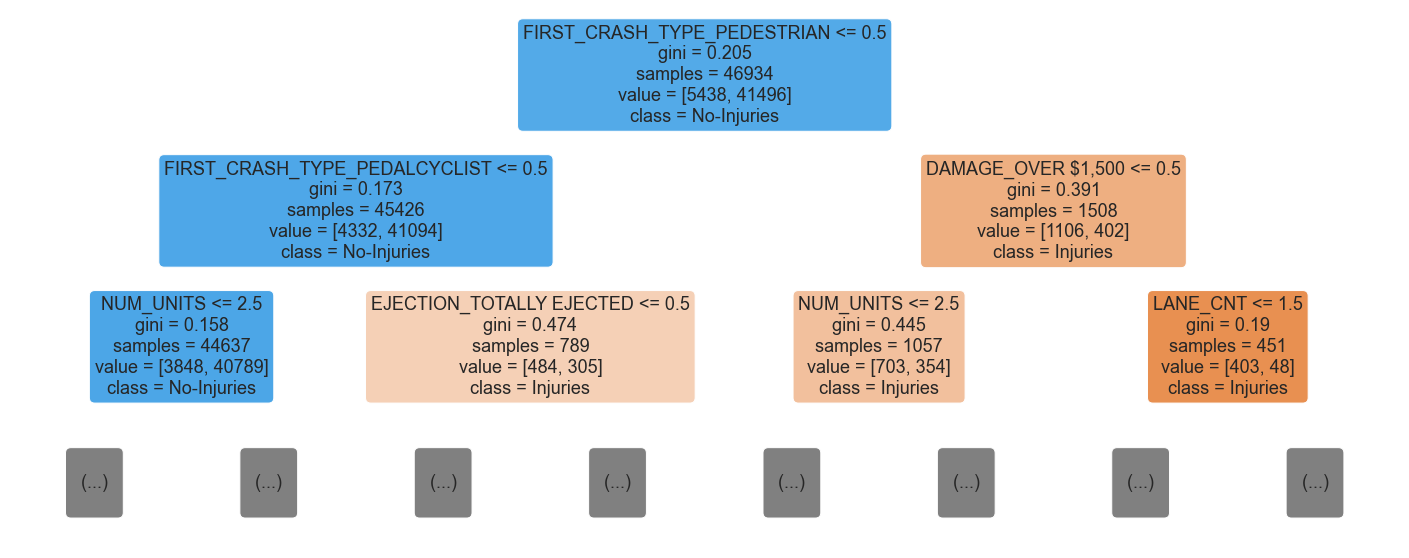

In [158]:
fn = X_train.columns.tolist()
cn = ['Injuries', 'No-Injuries']
plt.figure(figsize=(25,10))
tree_visual = tree.plot_tree(clf_dt,
               feature_names = fn, 
               class_names = cn,
               max_depth = 2,
               fontsize = 18,
               rounded = True,
               filled = True)

- First box: Gini = 1 - (5438/46934)^2 - (41496/46934)^2, Majority = class, header = feature to split

- Samples = number of current samples, values = seperated number of each class

# Importance of features

**Feature Importance:** to tell the relative importance of different features in the data

- Use the **information gain** at each stage of tree to the determine the information gain between different feature

- Calculate by considering **feature each split**; # of **data point** * **information gain**, then normalize the result

- Feature importance differs for each decision tree, all **results are combined and averaged**

---

**Information Gain:** based on information theory, Gini Criteria as a default in Python

- Choose the branch with lower **Gini Impurity**; Gini = 1 - (Sum of probability of each target class)^2

- **Best value** would be to have a impurity of 0, which means having a branch with **100% one target class**

- Iterate through the feature to find the best feature to split

In [159]:
# Pick the top x features from RandomForest based on the importance
feature_imp = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending=False).head(40)

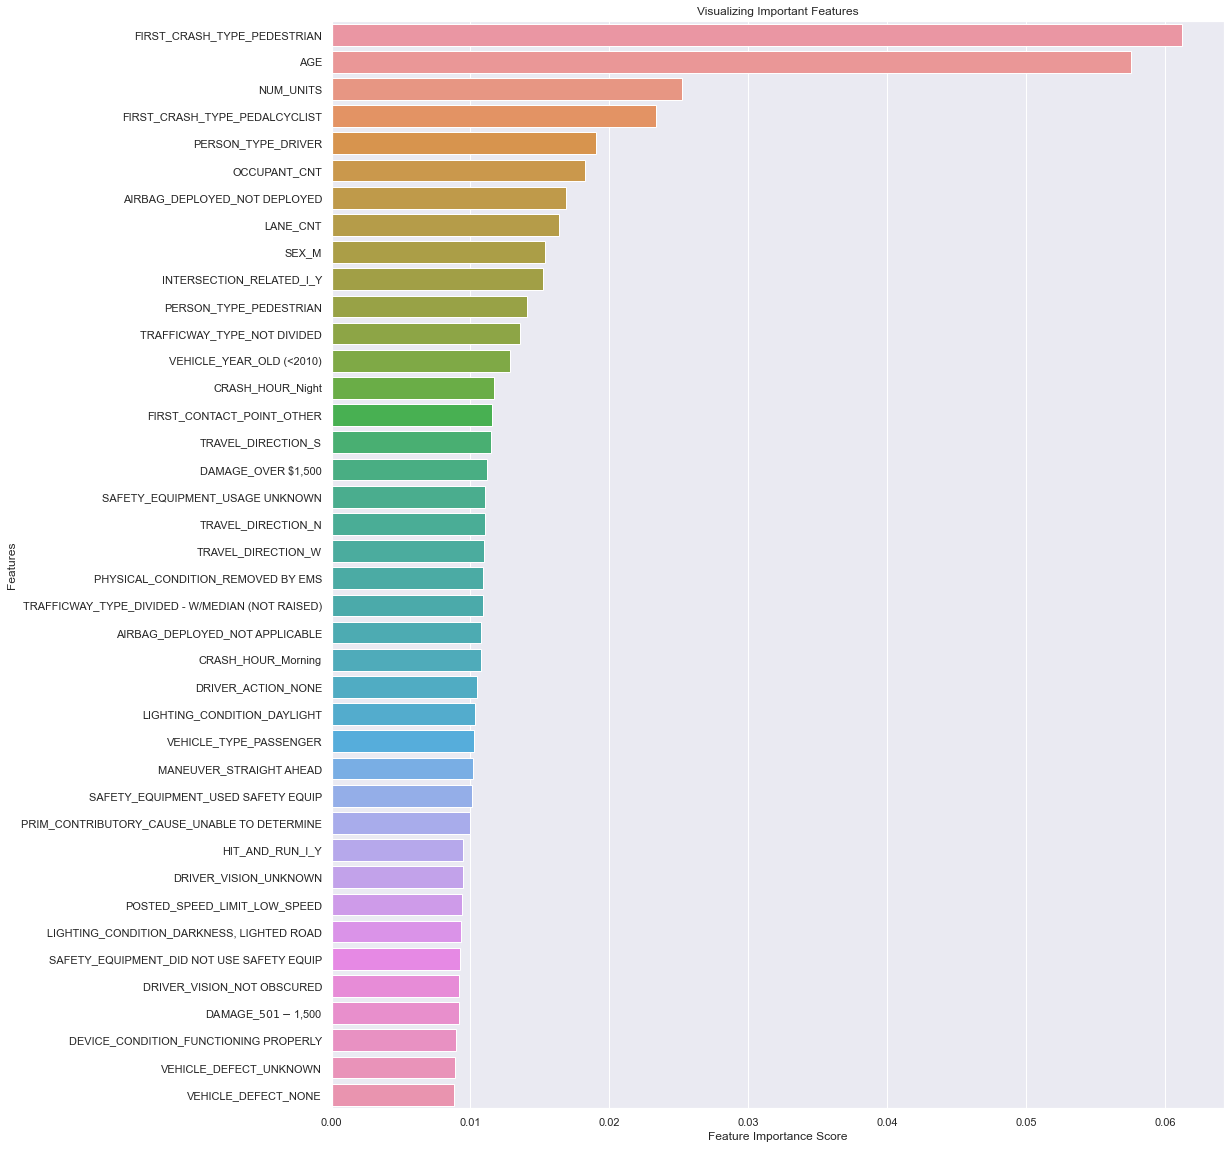

In [160]:
plt.figure(figsize=(16, 20))
sns.barplot(x = feature_imp, y = feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')

plt.show()

In [161]:
# Pick the most critical ones to analyze in depth
feature_imp = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False).head(25)
feature_imp

FIRST_CRASH_TYPE_PEDESTRIAN                        0.061213
AGE                                                0.057556
NUM_UNITS                                          0.025237
FIRST_CRASH_TYPE_PEDALCYCLIST                      0.023358
PERSON_TYPE_DRIVER                                 0.019032
OCCUPANT_CNT                                       0.018279
AIRBAG_DEPLOYED_NOT DEPLOYED                       0.016853
LANE_CNT                                           0.016362
SEX_M                                              0.015353
INTERSECTION_RELATED_I_Y                           0.015187
PERSON_TYPE_PEDESTRIAN                             0.014092
TRAFFICWAY_TYPE_NOT DIVIDED                        0.013543
VEHICLE_YEAR_OLD (<2010)                           0.012865
CRASH_HOUR_Night                                   0.011721
FIRST_CONTACT_POINT_OTHER                          0.011535
TRAVEL_DIRECTION_S                                 0.011462
DAMAGE_OVER $1,500                      

# Analysis of the model and result

## Findings & Results

**Feature Importance in details**

| **Feature** | **Description** | **Insights** |
|:-----|:----:|----:|
| FIRST_CRASH_TYPE_PEDESTRIAN | Type of first collision in crash; with Pedestrian | HIGH |
| AGE | Age of the driver or person in crash | HIGH |
| NUM_UNITS | Number of units involved in the crash | MEDIUM |
| FIRST_CRASH_TYPE_PEDALCYCLIST | Type of first collision in crash; with Pedalcyclist | HIGH |
| PERSON_TYPE_DRIVER | Type of roadway user involved in crash | LOW |
| OCCUPANT_CNT | The number of people in the unit, as determined by the reporting officer | MEDIUM |
| AIRBAG_DEPLOYED_NOT DEPLOYED | Whether vehicle occupant airbag deployed as result of crash | HIGH |
| LANE_CNT  | Total number of through lanes in either direction | HIGH |
| INTERSECTION_RELATED_I | A field observation by the police officer whether an intersection played a role in the crash. | HIGH |
| SEX_M | Males as a driver | LOW |
| VEHICLE_YEAR_OLD (<2010) | The model year of the vehicle, if relevant | HIGH |
| TRAFFICWAY_TYPE_NOT DIVIDED | Trafficway type, as determined by reporting officer | HIGH |
| FIRST_CONTACT_POINT_OTHER  | The first contact point of the crash | LOW |
| CRASH_HOUR_Night | The hour of the day component of CRASH_DATE. | HIGH |
| TRAVEL_DIRECTION_S | The direction in which the unit was traveling prior to the crash | LOW |
| DAMAGE_OVER $1,500 | The damages caused by the crash | LOW |
| TRAVEL_DIRECTION_N | The direction in which the unit was traveling prior to the crash | LOW |
| PHYSICAL_CONDITION_REMOVED BY EMS | Driver’s apparent physical condition at time of crash | LOW |
| SAFETY_EQUIPMENT_USAGE UNKNOWN | Safety equipment used by vehicle occupant in crash | LOW |
| PERSON_TYPE_PEDESTRIAN | Type of roadway user involved in crash | HIGH |

---

**Insights Level**

- **High:** features can be used to educate people, can used for fiting the model, etc. (Lane cnt, age, crash type)

- **Medium:** useful features but there are nothings to educate because it is a common sense (Occupant number, Number_Units, etc.)

- **Low:** features caused by post-crash (Damage from crashes), features based on facts (Travel direction, etc.)


---

**Overview and hyphothesis from the findings**

- The prob of injuries is caused when the **crashes happen with pedestrian and pedalcyclist**; very high number

- **Airbag deploy** can highly affect the probability of getting injured

- **Number of lane** plays an important role for the probability, especially when the lane is **not divided**

- **Intersection** is one factor to highly cause the probability of the outcome

- When the **vehicles are old** (< 2010), the risks of injuries are much higher. It should be cross-checked with airbag deploy

- When it is during **the night**, the number of crashes is much higher; also prove the geolocation data

- The drivers and people involved in the crashes don't use **safety equipment**

- Probability of getting injured is high, when the crash is **hit-and-run**

- **Posted speed limit** during the crash is identified as low


**Action-to-take from the findings**

- Some features are affecting the outcome, some imputations are not **properly done** (UNKNOWN)

- **Correlated features** will be given equal or similar importance, but overall reduced importance. Interaction effects need to be considered, such as vehicle_age and airbag_deploy

- Some insights can be used to educate people, especially those which are not **common sense**

- Build the **baseline model** again with the important features and compare the results

- Find way to improve the model **by experimenting** (feature engineering, revisiting last sprint, and feature selection)


## Interpretation of the model

### Partial Dependence Plots

**PD Plots**

- Show how **each feature or predictor** affects the model's predictions

- is calculated only after the model has been fit

- assumed that the feature(s) for which the partial dependence is computed are **not correlated** with other features

**Overview of Partial Dependence Plot**

- Tell us about the **interaction** between the target response and the target feature

- At **each value of the variable**, the model is evaluated for all observations of the other model inputs, and the output is then averaged

- Consider **each data point of the selected features**, the outcome is predicted without that datapoint to see the effect of leaving that specific data point

- The relationship they depict is only valid if the variable of interest **does not interact strongly** with other model inputs.


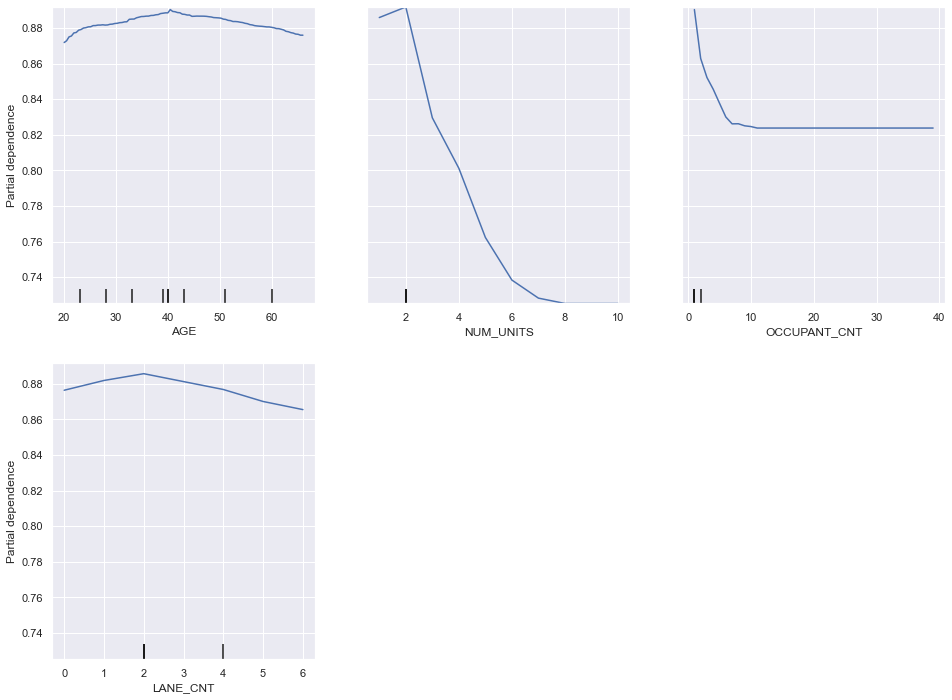

In [162]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize = (16, 12))
plot_partial_dependence(clf, features = ['AGE', 'NUM_UNITS', 'OCCUPANT_CNT', 'LANE_CNT'], # column numbers of plots we want to show
                        X = X_train,
                        fig = fig) # number of values to plot on x axis

plt.show()

**The findings from Partial Dependence Plots (Numerical Features)**

- The probability of injuries is high when the driver **age is around 40**, it increases slightly from age 20 to 40, then drops 

- The probability of injuries is high when the **number of involved units equals to 2** and then drop significantly

- The probability of injuries is high when the **number of occupants equals to 2** and then drop significantly

- The probability of injuries is high when the **lane equals to 2**, with some slight drops after that

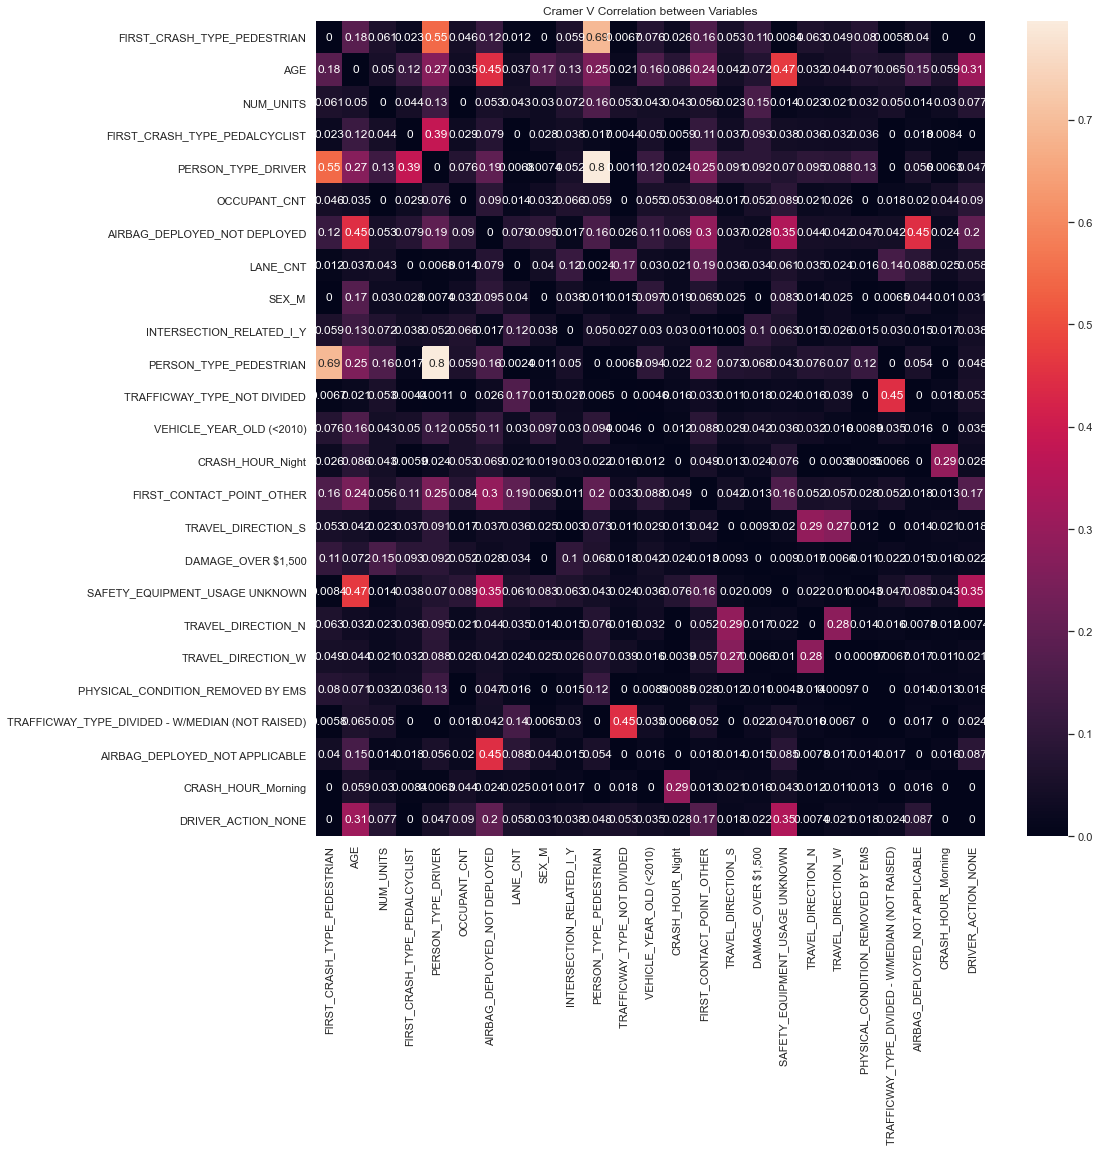

In [163]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols = feature_imp.index.tolist()
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(X_train[col1], X_train[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

**Correated important features**

- AGE and AIRBAG_DEPLOYED_NOT DEPLOYED

- PERSON_TYPE_DRIVER and SAFETY_EQUIPMENT_DO NOT USE SAFETY EQUIPMENT

**Rejected insights**

- AIRBAG_DEPLOYED_NOT DEPLOYED and VEHICLE_YEAR

- INTERSECTION_RELATED_I and FIRST_CONTACT_POINT

**AGE and AIRBAG_DEPLOYED_NOT DEPLOYED**

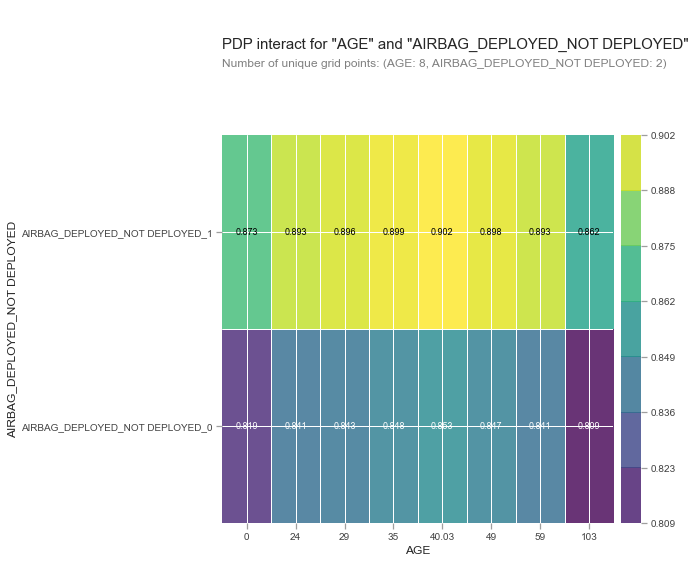

In [164]:
from pdpbox import pdp, get_dataset, info_plots

inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), features=['AGE', 'AIRBAG_DEPLOYED_NOT DEPLOYED'])

fig, axes = pdp.pdp_interact_plot(inter1, ['AGE', 'AIRBAG_DEPLOYED_NOT DEPLOYED'], plot_type='grid',  plot_pdp = False)

**AGE and SEX_M**

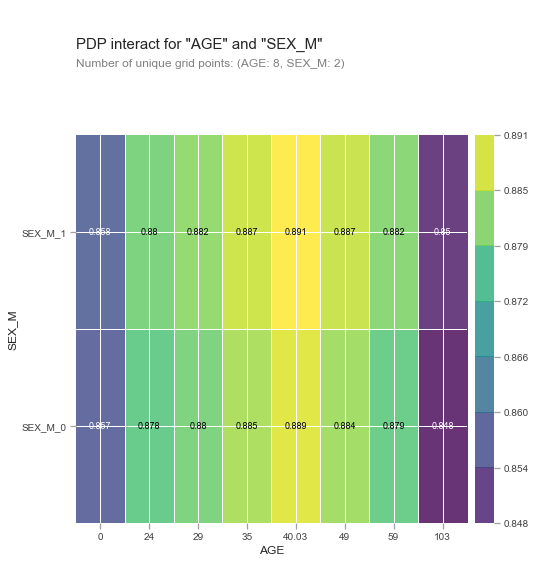

In [165]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), features=['AGE', 'SEX_M'])

fig, axes = pdp.pdp_interact_plot(inter1, ['AGE', 'SEX_M'], plot_type='grid',  plot_pdp = False)

**AGE and SAFETY_EQUIPMENT_DID NOT USE SAFETY EQUIP**

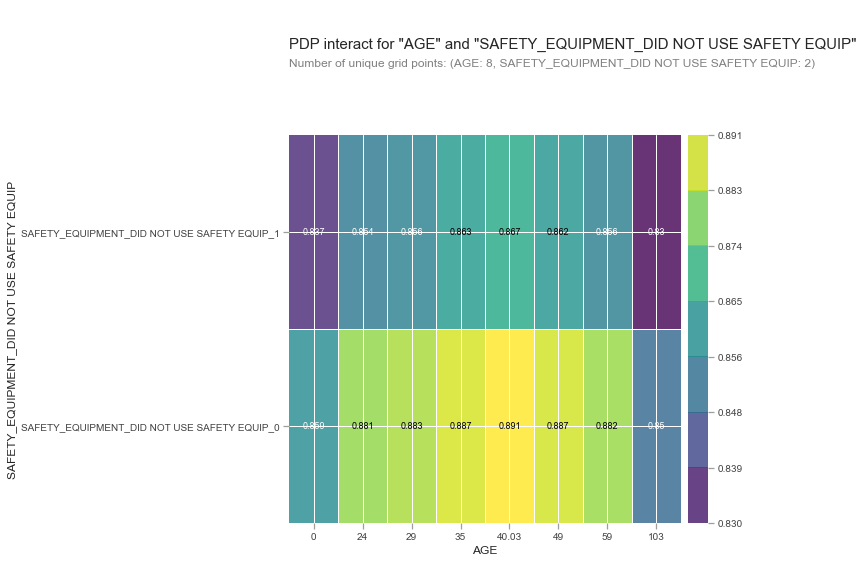

In [166]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), features=['AGE', 'SAFETY_EQUIPMENT_DID NOT USE SAFETY EQUIP'])

fig, axes = pdp.pdp_interact_plot(inter1, ['AGE', 'SAFETY_EQUIPMENT_DID NOT USE SAFETY EQUIP'], plot_type='grid',  plot_pdp = False)

**AGE and CRASH_HOUR_Night**

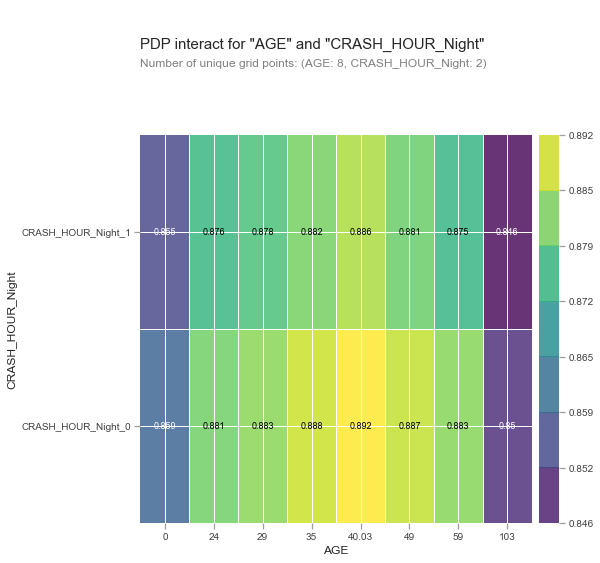

In [167]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), features=['AGE', 'CRASH_HOUR_Night'])

fig, axes = pdp.pdp_interact_plot(inter1, ['AGE', 'CRASH_HOUR_Night'], plot_type='grid',  plot_pdp = False)

**LANE_CNT and CRASH_HOUR_Night**

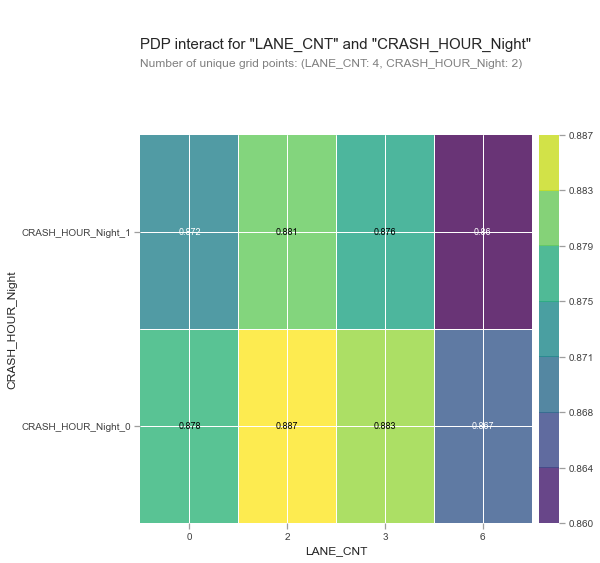

In [168]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), features=['LANE_CNT', 'CRASH_HOUR_Night'])

fig, axes = pdp.pdp_interact_plot(inter1, ['LANE_CNT', 'CRASH_HOUR_Night'], plot_type='grid',  plot_pdp = False)

**LANE_CNT and TRAFFICWAY_TYPE_NOT DIVIDED**

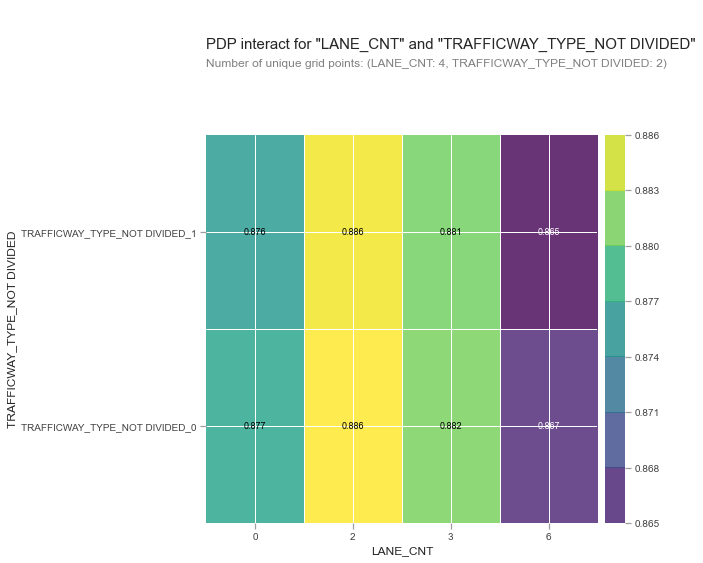

In [169]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), features=['LANE_CNT', 'TRAFFICWAY_TYPE_NOT DIVIDED'])

fig, axes = pdp.pdp_interact_plot(inter1, ['LANE_CNT', 'TRAFFICWAY_TYPE_NOT DIVIDED'], plot_type='grid',  plot_pdp = False)

**TRAFFICWAY_TYPE_NOT DIVIDED and CRASH_HOUR_Night**

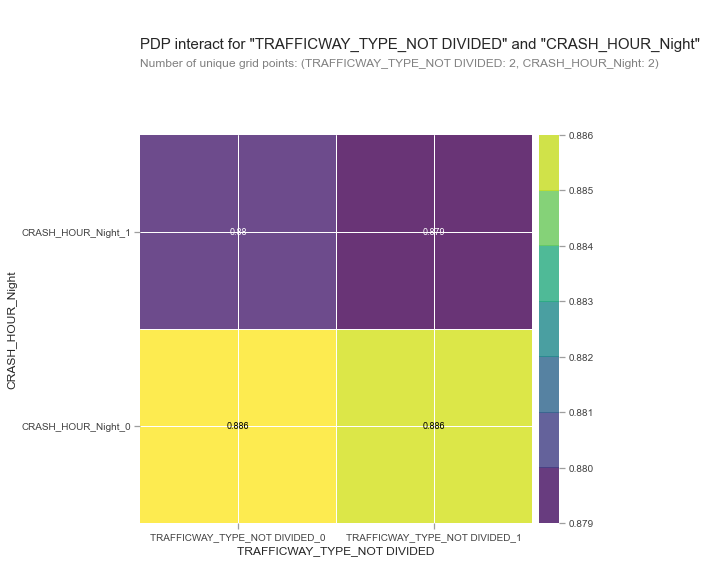

In [170]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), features=['TRAFFICWAY_TYPE_NOT DIVIDED', 'CRASH_HOUR_Night'])

fig, axes = pdp.pdp_interact_plot(inter1, ['TRAFFICWAY_TYPE_NOT DIVIDED', 'CRASH_HOUR_Night'], plot_type='grid',  plot_pdp = False)

**AIRBAG_DEPLOYED_NOT DEPLOYED' and 'VEHICLE_YEAR_OLD (<2010)**

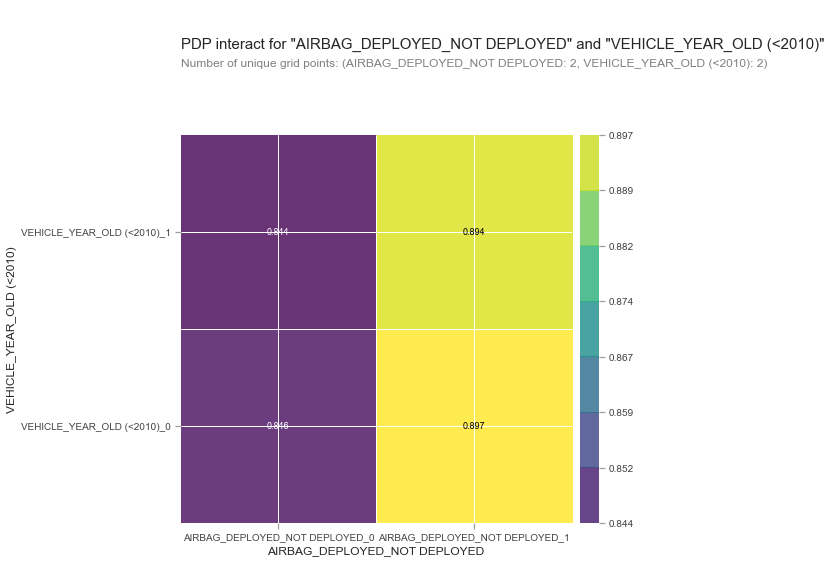

In [171]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), 
    features=['AIRBAG_DEPLOYED_NOT DEPLOYED', 'VEHICLE_YEAR_OLD (<2010)'])

fig, axes = pdp.pdp_interact_plot(inter1, ['AIRBAG_DEPLOYED_NOT DEPLOYED', 'VEHICLE_YEAR_OLD (<2010)'], plot_type='grid',  plot_pdp = False)

**FIRST_CRASH_TYPE_PEDESTRIAN and LANE_CNT**

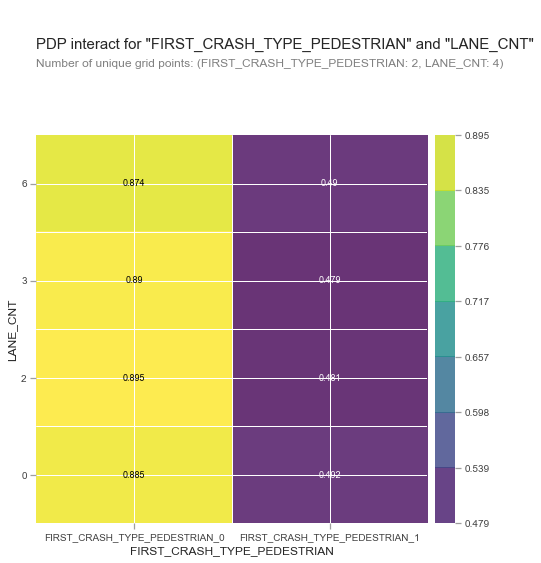

In [172]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), 
    features=['FIRST_CRASH_TYPE_PEDESTRIAN', 'LANE_CNT'])

fig, axes = pdp.pdp_interact_plot(inter1, ['FIRST_CRASH_TYPE_PEDESTRIAN', 'LANE_CNT'], plot_type='grid',  plot_pdp = False)

**CRASH_HOUR_Night, INTERSECTION_RELATED_I_Y**

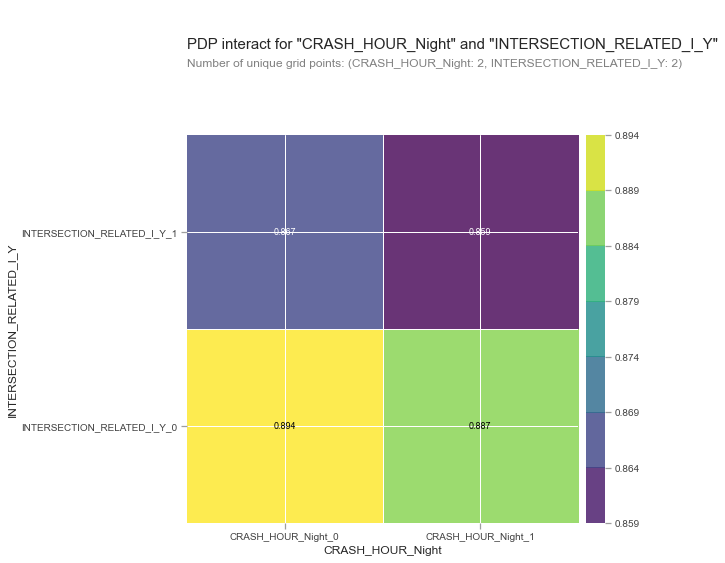

In [173]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), 
    features=['CRASH_HOUR_Night', 'INTERSECTION_RELATED_I_Y'])

fig, axes = pdp.pdp_interact_plot(inter1, ['CRASH_HOUR_Night', 'INTERSECTION_RELATED_I_Y'], plot_type='grid',  plot_pdp = False)

**VEHICLE_YEAR_OLD (<2010), CRASH_HOUR_Night**

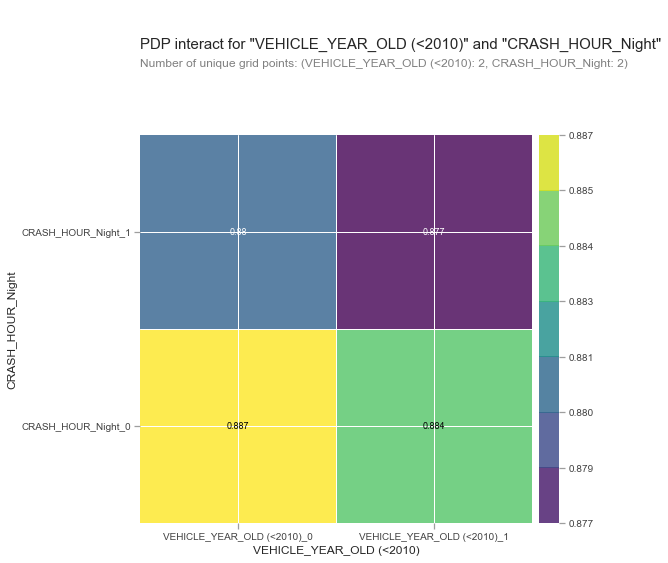

In [174]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), 
    features=['VEHICLE_YEAR_OLD (<2010)', 'CRASH_HOUR_Night'])

fig, axes = pdp.pdp_interact_plot(inter1, ['VEHICLE_YEAR_OLD (<2010)', 'CRASH_HOUR_Night'], plot_type='grid',  plot_pdp = False)

**TRAFFICWAY_TYPE_NOT DIVIDED and FIRST_CRASH_TYPE_PEDESTRIAN**

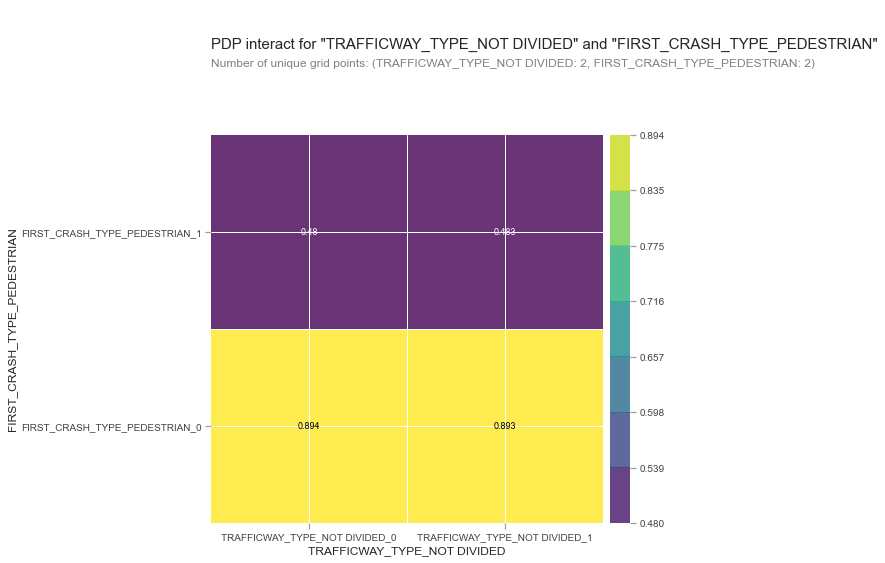

In [175]:
inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), 
    features=['TRAFFICWAY_TYPE_NOT DIVIDED', 'FIRST_CRASH_TYPE_PEDESTRIAN'])

fig, axes = pdp.pdp_interact_plot(inter1, ['TRAFFICWAY_TYPE_NOT DIVIDED', 'FIRST_CRASH_TYPE_PEDESTRIAN'], plot_type='grid',  plot_pdp = False)

## Overall Insights/Findings and Action-to-take

**Insights**

- People **age between 40-5**0 have the highest probability of getting injured, when **no air-bag deployed**

- **Males** who are around **40-50 years** old also affect probability of getting injured

- **Old people** driving during **the night** **NOT** affect probability of getting injured

- **Old vehicle** driven during the night **NOT** affect probability of getting injured

- The probability of injuries is high when the driver **age is around 40**, it increases slightly from age 20 to 40, then drops 

- **No correlation** between vehicle age and air-bag not deployed

- More combination of important features should be created

**Action-to-take**

- All **important features** should be further analysed

- Some features are affecting the outcome, **some imputations** are not properly done (UNKNOWN)

- Find way to improve the model by **experimenting** (feature engineering, missing value imputation, and interaction effects)

- Build the **baseline model again** with the important features and compare the results

# Experiment on improving the model

In order to increase the **model performance**, and get **more insights** from the model

- Revisiting last sprint

- Feature engineering

- Feature selection

## Revisiting last sprint

**The columns that we decide to return**

- SEC_CONTRIBUTORY_CAUSE

In [176]:
train_new['SEC_CONTRIBUTORY_CAUSE'] = raw_train['SEC_CONTRIBUTORY_CAUSE']
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46934 entries, 29244 to 15795
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   POSTED_SPEED_LIMIT       46934 non-null  object 
 1   TRAFFIC_CONTROL_DEVICE   46934 non-null  object 
 2   DEVICE_CONDITION         46934 non-null  object 
 3   WEATHER_CONDITION        46934 non-null  object 
 4   LIGHTING_CONDITION       46934 non-null  object 
 5   FIRST_CRASH_TYPE         46934 non-null  object 
 6   TRAFFICWAY_TYPE          46934 non-null  object 
 7   LANE_CNT                 46934 non-null  int64  
 8   ROADWAY_SURFACE_COND     46934 non-null  object 
 9   ROAD_DEFECT              46934 non-null  object 
 10  INTERSECTION_RELATED_I   46934 non-null  object 
 11  HIT_AND_RUN_I            46934 non-null  object 
 12  DAMAGE                   46934 non-null  object 
 13  PRIM_CONTRIBUTORY_CAUSE  46934 non-null  object 
 14  NUM_UNITS         

**Reverse encoded features**

- VEHICLE_YEAR (OLD/NEW)

- POSTED_SPEED_LIMIT (LOW/HIGH)

In [177]:
train_new = train_new.drop(['VEHICLE_YEAR', 'POSTED_SPEED_LIMIT'], axis = 1)

In [178]:
train_new['VEHICLE_YEAR'] = raw_train['VEHICLE_YEAR']
train_new['POSTED_SPEED_LIMIT'] = raw_train['POSTED_SPEED_LIMIT']
train_new["VEHICLE_YEAR"] = train_new.VEHICLE_YEAR.astype(float)
train_new["POSTED_SPEED_LIMIT"] = train_new.POSTED_SPEED_LIMIT.astype(float)
train_new.head()

,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ROADWAY_SURFACE_COND,ROAD_DEFECT,INTERSECTION_RELATED_I,HIT_AND_RUN_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,NUM_UNITS,CRASH_HOUR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT,FIRST_CONTACT_POINT,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,INJURY,SEC_CONTRIBUTORY_CAUSE,VEHICLE_YEAR,POSTED_SPEED_LIMIT
29244,SIGN,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,ANGLE,DIVIDED - W/MEDIAN BARRIER,4,OTHER,UNKNOWN,Y,N,"OVER $1,500",DISREGARDING TRAFFIC SIGNALS,2,Afternoon,OTHER,SPORT UTILITY VEHICLE (SUV),PERSONAL,S,STRAIGHT AHEAD,1.0,SIDE,DRIVER,M,26.000000,USED SAFETY EQUIP,DEPLOYED,NONE,NONE,NOT OBSCURED,NORMAL,NOT INJURED,FAILING TO YIELD RIGHT-OF-WAY,2017.0,30.0
22376,SIGN,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,SIDESWIPE SAME DIRECTION,ONE-WAY,3,WET,NO DEFECTS,N,N,"$501 - $1,500",IMPROPER OVERTAKING/PASSING,2,Afternoon,NONE,PASSENGER,TAXI/FOR HIRE,S,LANE,1.0,SIDE,DRIVER,M,51.000000,USAGE UNKNOWN,NOT DEPLOYED,NONE,IMPROPER LANE CHANGE,UNKNOWN,UNKNOWN,NOT INJURED,UNABLE TO DETERMINE,NaN,30.0
49790,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,OTHER OBJECT,NOT DIVIDED,2,DRY,"RUT, HOLES",N,N,"OVER $1,500",ROAD CONSTRUCTION/MAINTENANCE,1,Afternoon,NONE,PASSENGER,PERSONAL,S,STRAIGHT AHEAD,1.0,OTHER,DRIVER,M,73.000000,USED SAFETY EQUIP,NOT DEPLOYED,NONE,NONE,NOT OBSCURED,NORMAL,NOT INJURED,NOT APPLICABLE,2019.0,30.0
32552,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,ALLEY,2,DRY,NO DEFECTS,N,N,"$501 - $1,500",UNABLE TO DETERMINE,2,Morning,NONE,TRUCK - SINGLE UNIT,UNKNOWN/NA,E,TURN,1.0,OTHER,DRIVER,F,40.027496,USAGE UNKNOWN,NOT APPLICABLE,NONE,NONE,NOT OBSCURED,NORMAL,NOT INJURED,NOT APPLICABLE,NaN,30.0
1957,SIGN,FUNCTIONING PROPERLY,CLEAR,DARKNESS,TURNING,FOUR WAY,2,DRY,NO DEFECTS,N,Y,"OVER $1,500",IMPROPER TURNING/NO SIGNAL,2,Early_morning,NONE,PASSENGER,PERSONAL,E,TURN,1.0,OTHER,DRIVER,F,30.000000,USED SAFETY EQUIP,NOT DEPLOYED,NONE,UNKNOWN,NOT OBSCURED,NORMAL,NOT INJURED,UNABLE TO DETERMINE,2008.0,30.0


**Change UNKNOWN, UNABLE TO DETERMINE to NaN**

In [179]:
train_new = train_new.replace("UNKNOWN", np.nan)
train_new = train_new.replace("UNKNOWN/NA", np.nan)
train_new = train_new.replace("USAGE UNKNOWN", np.nan)
train_new = train_new.replace("UNABLE TO DETERMINE", np.nan)

In [180]:
# Check if there is any unknown left in the DataFrame
exists = "UNKNOWN" in train_new['ROAD_DEFECT']
print(exists)

train_new.head()

False


,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ROADWAY_SURFACE_COND,ROAD_DEFECT,INTERSECTION_RELATED_I,HIT_AND_RUN_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,NUM_UNITS,CRASH_HOUR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT,FIRST_CONTACT_POINT,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,INJURY,SEC_CONTRIBUTORY_CAUSE,VEHICLE_YEAR,POSTED_SPEED_LIMIT
29244,SIGN,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,ANGLE,DIVIDED - W/MEDIAN BARRIER,4,OTHER,NaN,Y,N,"OVER $1,500",DISREGARDING TRAFFIC SIGNALS,2,Afternoon,OTHER,SPORT UTILITY VEHICLE (SUV),PERSONAL,S,STRAIGHT AHEAD,1.0,SIDE,DRIVER,M,26.000000,USED SAFETY EQUIP,DEPLOYED,NONE,NONE,NOT OBSCURED,NORMAL,NOT INJURED,FAILING TO YIELD RIGHT-OF-WAY,2017.0,30.0
22376,SIGN,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,SIDESWIPE SAME DIRECTION,ONE-WAY,3,WET,NO DEFECTS,N,N,"$501 - $1,500",IMPROPER OVERTAKING/PASSING,2,Afternoon,NONE,PASSENGER,TAXI/FOR HIRE,S,LANE,1.0,SIDE,DRIVER,M,51.000000,NaN,NOT DEPLOYED,NONE,IMPROPER LANE CHANGE,NaN,NaN,NOT INJURED,NaN,NaN,30.0
49790,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,OTHER OBJECT,NOT DIVIDED,2,DRY,"RUT, HOLES",N,N,"OVER $1,500",ROAD CONSTRUCTION/MAINTENANCE,1,Afternoon,NONE,PASSENGER,PERSONAL,S,STRAIGHT AHEAD,1.0,OTHER,DRIVER,M,73.000000,USED SAFETY EQUIP,NOT DEPLOYED,NONE,NONE,NOT OBSCURED,NORMAL,NOT INJURED,NOT APPLICABLE,2019.0,30.0
32552,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,ALLEY,2,DRY,NO DEFECTS,N,N,"$501 - $1,500",NaN,2,Morning,NONE,TRUCK - SINGLE UNIT,NaN,E,TURN,1.0,OTHER,DRIVER,F,40.027496,NaN,NOT APPLICABLE,NONE,NONE,NOT OBSCURED,NORMAL,NOT INJURED,NOT APPLICABLE,NaN,30.0
1957,SIGN,FUNCTIONING PROPERLY,CLEAR,DARKNESS,TURNING,FOUR WAY,2,DRY,NO DEFECTS,N,Y,"OVER $1,500",IMPROPER TURNING/NO SIGNAL,2,Early_morning,NONE,PASSENGER,PERSONAL,E,TURN,1.0,OTHER,DRIVER,F,30.000000,USED SAFETY EQUIP,NOT DEPLOYED,NONE,NaN,NOT OBSCURED,NORMAL,NOT INJURED,NaN,2008.0,30.0


## Feature Engineering

**Benefits from feature engineering**

- New features can be used to improve the performance of machine learning algorithms

- Process of using domain knowledge to extract or create new features


**Feature Engineering Method**

- Brainstorming or testing features

- Deciding what features to create

- Creating features

- Checking how the features work with your model

- Improving your features if needed

- Go back to brainstorming/creating more features until the work is done.

### Categorical Feature Engineering

In [181]:
train_new.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46934 entries, 29244 to 15795
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   TRAFFIC_CONTROL_DEVICE   46934 non-null  object
 1   DEVICE_CONDITION         44435 non-null  object
 2   WEATHER_CONDITION        45433 non-null  object
 3   LIGHTING_CONDITION       45786 non-null  object
 4   FIRST_CRASH_TYPE         46934 non-null  object
 5   TRAFFICWAY_TYPE          46526 non-null  object
 6   ROADWAY_SURFACE_COND     44359 non-null  object
 7   ROAD_DEFECT              40461 non-null  object
 8   INTERSECTION_RELATED_I   46934 non-null  object
 9   HIT_AND_RUN_I            46934 non-null  object
 10  DAMAGE                   46934 non-null  object
 11  PRIM_CONTRIBUTORY_CAUSE  31570 non-null  object
 12  CRASH_HOUR               46934 non-null  object
 13  VEHICLE_DEFECT           26118 non-null  object
 14  VEHICLE_TYPE             40979 non

In [182]:
for col in train_new.select_dtypes('object'):
    print('\033[1m', col, '\033[0m')
    print(train_new[col].unique())
    print('')
    print('')

 TRAFFIC_CONTROL_DEVICE 
['SIGN' 'NO_SIGN']


 DEVICE_CONDITION 
['FUNCTIONING PROPERLY' 'NO CONTROLS' nan 'OTHER' 'FUNCTIONING IMPROPERLY'
 'NOT FUNCTIONING' 'MISSING' 'WORN REFLECTIVE MATERIAL']


 WEATHER_CONDITION 
['CLEAR' 'RAIN' 'CLOUDY/OVERCAST' 'SNOW' nan 'FREEZING RAIN/DRIZZLE'
 'OTHER' 'BLOWING SNOW' 'FOG/SMOKE/HAZE' 'SEVERE CROSS WIND GATE'
 'SLEET/HAIL' 'BLOWING SAND, SOIL, DIRT']


 LIGHTING_CONDITION 
['DAYLIGHT' 'DARKNESS' 'DARKNESS, LIGHTED ROAD' 'DAWN' 'DUSK' nan]


 FIRST_CRASH_TYPE 
['ANGLE' 'SIDESWIPE SAME DIRECTION' 'OTHER OBJECT' 'PARKED MOTOR VEHICLE'
 'TURNING' 'REAR END' 'PEDESTRIAN' 'REAR TO FRONT' 'PEDALCYCLIST'
 'FIXED OBJECT' 'SIDESWIPE OPPOSITE DIRECTION' 'REAR TO SIDE' 'HEAD ON'
 'REAR TO REAR' 'OTHER NONCOLLISION' 'ANIMAL' 'OVERTURNED' 'TRAIN']


 TRAFFICWAY_TYPE 
['DIVIDED - W/MEDIAN BARRIER' 'ONE-WAY' 'NOT DIVIDED' 'ALLEY' 'FOUR WAY'
 'OTHER' 'DIVIDED - W/MEDIAN (NOT RAISED)' 'FIVE POINT, OR MORE'
 'PARKING LOT' nan 'CENTER TURN LANE' 'T-INTERSECTION' 

**Reduce Levels for PRIM_CONTRIBUTORY_CAUSE**

- Feature contains more than 18 levels 

- Levels can be grouped into 4 main categories, including

- **IMPROPER ACTION BY THE DRIVER:** The crashes were happened by the improper action from the driver (Diregarding traffic, drinking, texting, reckless & careless)

- **EXTERNAL UNFORSEEABLE:** crashes were influenced by unforeseeable event (Animals)

- **EXTERNAL FORSEEABLE:** crashes were influenced by foreseeable event (Contruction, bus stop, distraction from internal devices)

- **DRIVING QUALIFICATION:** Drivers lack basic knowledge about driving (driving wrong side, failing to follow the traffic sign, not knowing the proper distance between the cars)

In [183]:
train_new.PRIM_CONTRIBUTORY_CAUSE.unique()

x = train.drop(drop_list, axis=1)

In [184]:
dict_prim = {'DISREGARDING TRAFFIC SIGNALS' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER OVERTAKING/PASSING' : 'IMPROPER ACTION BY THE DRIVER',
            'ROAD CONSTRUCTION/MAINTENANCE' : 'EXTERNAL FORESEEABLE', 'nan' : np.nan, 'IMPROPER TURNING/NO SIGNAL' : 'IMPROPER ACTION BY THE DRIVER',
            'FOLLOWING TOO CLOSELY' : 'IMPROPER ACTION BY THE DRIVER', 'DISTRACTION - FROM INSIDE VEHICLE' : 'IMPROPER ACTION BY THE DRIVER',
            'IMPROPER BACKING' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER LANE USAGE': 'IMPROPER ACTION BY THE DRIVER',
            'FAILING TO YIELD RIGHT-OF-WAY' : 'IMPROPER ACTION BY THE DRIVER', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE' : 'DRIVING QUALIFICATION',
            'DISREGARDING STOP SIGN' : 'IMPROPER ACTION BY THE DRIVER', 'NOT APPLICABLE' : np.nan, 'FAILING TO REDUCE SPEED TO AVOID CRASH' : 'DRIVING QUALIFICATION',
            'DISREGARDING ROAD MARKINGS' : 'EXTERNAL FORESEEABLE', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER' : 'IMPROPER ACTION BY THE DRIVER',
            'DISTRACTION - FROM OUTSIDE VEHICLE' : 'EXTERNAL UNFORSEEABLE', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST' : 'EXTERNAL UNFORSEEABLE',
            'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)' : 'IMPROPER ACTION BY THE DRIVER',
            'WEATHER' : 'EXTERNAL FORESEEABLE', 'DRIVING ON WRONG SIDE/WRONG WAY' : 'DRIVING QUALIFICATION', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)' : 'EXTERNAL UNFORSEEABLE',
            'EXCEEDING AUTHORIZED SPEED LIMIT' : 'IMPROPER ACTION BY THE DRIVER', 'EXCEEDING SAFE SPEED FOR CONDITIONS': 'IMPROPER ACTION BY THE DRIVER',
            'PHYSICAL CONDITION OF DRIVER' : 'DRIVING QUALIFICATION', 'DISREGARDING OTHER TRAFFIC SIGNS' : 'IMPROPER ACTION BY THE DRIVER',
            'EQUIPMENT - VEHICLE CONDITION' : 'EXTERNAL FORESEEABLE', 'RELATED TO BUS STOP' : 'EXTERNAL FORESEEABLE', 'CELL PHONE USE OTHER THAN TEXTING' : 'IMPROPER ACTION BY THE DRIVER',
            'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT' : 'IMPROPER ACTION BY THE DRIVER', 'PASSING STOPPED SCHOOL BUS' : 'IMPROPER ACTION BY THE DRIVER',
            'ROAD ENGINEERING/SURFACE/MARKING DEFECTS' : 'EXTERNAL FORESEEABLE', 'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)' : 'IMPROPER ACTION BY THE DRIVER',
            'TEXTING' : 'IMPROPER ACTION BY THE DRIVER', 'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)' : 'EXTERNAL FORESEEABLE',
            'TURNING RIGHT ON RED' : 'IMPROPER ACTION BY THE DRIVER', 'DISREGARDING YIELD SIGN' : 'IMPROPER ACTION BY THE DRIVER',
            'ANIMAL' : 'EXTERNAL UNFORSEEABLE', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT' : 'EXTERNAL UNFORSEEABLE'}


In [185]:
train_new['PRIM_CONTRIBUTORY_CAUSE'] = x["PRIM_CONTRIBUTORY_CAUSE"]
train_new['PRIM_CONTRIBUTORY_CAUSE'] = train_new["PRIM_CONTRIBUTORY_CAUSE"].map(dict_prim)

In [186]:
train_new.PRIM_CONTRIBUTORY_CAUSE.unique()

array(['IMPROPER ACTION BY THE DRIVER', 'EXTERNAL FORESEEABLE', nan,
       'DRIVING QUALIFICATION', 'EXTERNAL UNFORSEEABLE'], dtype=object)

**Reduce Levels for SEC_CONTRIBUTORY_CAUSE**

In [187]:
train_new.SEC_CONTRIBUTORY_CAUSE.unique()

y = train[:]

- Feature contains more than 15 levels 

- Levels can be grouped into 4 main categories, including (Save as primary)

- **IMPROPER ACTION BY THE DRIVER:** The crashes were happened by the improper action from the driver (Diregarding traffic, drinking, texting, reckless & careless)

- **EXTERNAL UNFORSEEABLE:** crashes were influenced by unforeseeable event (Animals)

- **EXTERNAL FORSEEABLE:** crashes were influenced by foreseeable event (Contruction, bus stop, distraction from internal devices)

- **DRIVING QUALIFICATION:** Drivers lack basic knowledge about driving (driving wrong side, failing to follow the traffic sign, not knowing the proper distance between the cars)

In [188]:
dict_sec = {'FAILING TO YIELD RIGHT-OF-WAY' : 'IMPROPER ACTION BY THE DRIVER', 'nan' : np.nan, 'NOT APPLICABLE' : np.nan,
           'DISTRACTION - FROM INSIDE VEHICLE' : 'EXTERNAL FORSEEABLE', 'IMPROPER OVERTAKING/PASSING' : 'IMPROPER ACTION BY THE DRIVER',
           'FAILING TO REDUCE SPEED TO AVOID CRASH' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER LANE USAGE' : 'IMPROPER ACTION BY THE DRIVER',
           'EXCEEDING SAFE SPEED FOR CONDITIONS' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER TURNING/NO SIGNAL' : 'IMPROPER ACTION BY THE DRIVER',
           'FOLLOWING TOO CLOSELY' : 'DRIVING QUALIFICATION', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE' : 'DRIVING QUALIFICATION',
           'WEATHER' : 'EXTERNAL FORSEEABLE', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER' : 'IMPROPER ACTION BY THE DRIVER',
           'DISTRACTION - FROM OUTSIDE VEHICLE' : 'EXTERNAL UNFORSEEABLE', 'DISREGARDING STOP SIGN' : 'IMPROPER ACTION BY THE DRIVER',
           'CELL PHONE USE OTHER THAN TEXTING' : 'IMPROPER ACTION BY THE DRIVER', 'PHYSICAL CONDITION OF DRIVER' : 'DRIVING QUALIFICATION',
           'IMPROPER BACKING' : 'IMPROPER ACTION BY THE DRIVER', 'EXCEEDING AUTHORIZED SPEED LIMIT' : 'IMPROPER ACTION BY THE DRIVER',
           'DISREGARDING TRAFFIC SIGNALS' : 'IMPROPER ACTION BY THE DRIVER', 'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'IMPROPER ACTION BY THE DRIVER',
           'DRIVING ON WRONG SIDE/WRONG WAY' : 'DRIVING QUALIFICATION', 'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'IMPROPER ACTION BY THE DRIVER',
           'ROAD CONSTRUCTION/MAINTENANCE' : 'EXTERNAL FORSEEABLE', 'EQUIPMENT - VEHICLE CONDITION' : 'EXTERNAL UNFORSEEABLE',
           'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)' : 'EXTERNAL UNFORSEEABLE', 'TURNING RIGHT ON RED' : 'IMPROPER ACTION BY THE DRIVER',
           'DISREGARDING ROAD MARKINGS' : 'IMPROPER ACTION BY THE DRIVER', 'DISREGARDING OTHER TRAFFIC SIGNS' : 'IMPROPER ACTION BY THE DRIVER',
           'BICYCLE ADVANCING LEGALLY ON RED LIGHT' : 'EXTERNAL UNFORSEEABLE', 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS' : 'EXTERNAL UNFORSEEABLE',
           'RELATED TO BUS STOP' : 'DRIVING QUALIFICATION', 'DISREGARDING YIELD SIGN' : 'IMPROPER ACTION BY THE DRIVER', 'OBSTRUCTED CROSSWALKS' : 'IMPROPER ACTION BY THE DRIVER',
           'ANIMAL' : 'EXTERNAL UNFORSEEABLE', 'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)' : 'EXTERNAL FORSEEABLE',
          'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST' : 'EXTERNAL UNFORSEEABLE', 'TEXTING' : 'IMPROPER ACTION BY THE DRIVER', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT' : 'IMPROPER ACTION BY THE DRIVER',
          'PASSING STOPPED SCHOOL BUS' : 'IMPROPER ACTION BY THE DRIVER'}


In [189]:
train_new['SEC_CONTRIBUTORY_CAUSE'] = y["SEC_CONTRIBUTORY_CAUSE"]
train_new['SEC_CONTRIBUTORY_CAUSE'] = train_new["SEC_CONTRIBUTORY_CAUSE"].map(dict_sec)

In [190]:
train_new.SEC_CONTRIBUTORY_CAUSE.unique()

array(['IMPROPER ACTION BY THE DRIVER', nan, 'EXTERNAL FORSEEABLE',
       'DRIVING QUALIFICATION', 'EXTERNAL UNFORSEEABLE'], dtype=object)

**DEVICE_CONDITION**

- Map two levels which are similar together (Missing and no controls)

- Mark other as unknown (missing value)

In [191]:
train_new['DEVICE_CONDITION'] = train_new['DEVICE_CONDITION'].replace("MISSING", 'NO CONTROLS')
train_new['DEVICE_CONDITION'] = train_new['DEVICE_CONDITION'].replace("OTHER", np.nan)

**TRAFFICWAY_TYPE**

- Combine similar levels (DIVIDED - W/MEDIAN BARRIER, DIVIDED - W/MEDIAN (NOT RAISED))

- Change Missing, not reported and unknown to missing values

In [192]:
train_new['TRAFFICWAY_TYPE'] = train_new['TRAFFICWAY_TYPE'].replace("DIVIDED - W/MEDIAN (NOT RAISED)", 'DIVIDED - W/MEDIAN')
train_new['TRAFFICWAY_TYPE'] = train_new['TRAFFICWAY_TYPE'].replace("DIVIDED - W/MEDIAN BARRIER", 'DIVIDED - W/MEDIAN')
train_new['TRAFFICWAY_TYPE'] = train_new['TRAFFICWAY_TYPE'].replace("UNKNOWN INTERSECTION TYPE", np.nan)
train_new['TRAFFICWAY_TYPE'] = train_new['TRAFFICWAY_TYPE'].replace("NOT REPORTED", np.nan)

**Engineer new features showing the number of causes**

- Primary and secondary causes can be redundant

- to identify if the number of causes affects the injuries

In [193]:
train_new['NUMBER_CAUSES'] = np.where(train_new['PRIM_CONTRIBUTORY_CAUSE'] == train_new['SEC_CONTRIBUTORY_CAUSE'], 1, 
                                      np.where((train_new['PRIM_CONTRIBUTORY_CAUSE'].isnull()) | 
                                               (train_new['SEC_CONTRIBUTORY_CAUSE'].isnull()), 1, 2))

In [194]:
train_new[train_new.NUMBER_CAUSES == 2]

,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ROADWAY_SURFACE_COND,ROAD_DEFECT,INTERSECTION_RELATED_I,HIT_AND_RUN_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,NUM_UNITS,CRASH_HOUR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT,FIRST_CONTACT_POINT,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,INJURY,SEC_CONTRIBUTORY_CAUSE,VEHICLE_YEAR,POSTED_SPEED_LIMIT,NUMBER_CAUSES
66119,SIGN,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,REAR END,NOT DIVIDED,4,DRY,NO DEFECTS,Y,N,"OVER $1,500",IMPROPER ACTION BY THE DRIVER,2,Afternoon,NaN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,1.0,REAR,DRIVER,M,77.000000,NaN,DEPLOYED,NONE,NONE,NOT OBSCURED,NORMAL,NOT INJURED,EXTERNAL FORSEEABLE,2013.0,30.0,2
29638,SIGN,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,CENTER TURN LANE,2,DRY,NO DEFECTS,Y,N,$500 OR LESS,EXTERNAL FORESEEABLE,3,Night,NaN,NaN,NaN,NaN,NaN,1.0,OTHER,PEDESTRIAN,F,57.000000,NaN,DEPLOYMENT UNKNOWN,NaN,NaN,NaN,NORMAL,INJURED,IMPROPER ACTION BY THE DRIVER,NaN,30.0,2
47559,SIGN,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDESTRIAN,DIVIDED - W/MEDIAN,2,DRY,NO DEFECTS,N,N,"$501 - $1,500",EXTERNAL UNFORSEEABLE,2,Morning,NaN,NaN,NaN,NaN,NaN,1.0,OTHER,PEDESTRIAN,M,22.000000,DID NOT USE SAFETY EQUIP,DEPLOYMENT UNKNOWN,NaN,NONE,NOT OBSCURED,NORMAL,INJURED,IMPROPER ACTION BY THE DRIVER,NaN,30.0,2
37714,SIGN,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,DIVIDED - W/MEDIAN,4,WET,NO DEFECTS,N,N,"OVER $1,500",EXTERNAL UNFORSEEABLE,1,Early_morning,NONE,SPORT UTILITY VEHICLE (SUV),PERSONAL,N,STRAIGHT AHEAD,1.0,FRONT,DRIVER,M,38.000000,USED SAFETY EQUIP,DEPLOYED,NONE,OTHER,NOT OBSCURED,NORMAL,NOT INJURED,EXTERNAL FORSEEABLE,2017.0,30.0,2
26581,SIGN,FUNCTIONING PROPERLY,CLEAR,DARKNESS,ANGLE,NOT DIVIDED,2,DRY,NO DEFECTS,N,N,"OVER $1,500",IMPROPER ACTION BY THE DRIVER,2,Night,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,3.0,FRONT,DRIVER,F,31.000000,USED SAFETY EQUIP,NOT DEPLOYED,NONE,NONE,NOT OBSCURED,NORMAL,INJURED,DRIVING QUALIFICATION,2004.0,30.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50015,SIGN,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN,2,WET,NO DEFECTS,Y,N,"OVER $1,500",DRIVING QUALIFICATION,2,Afternoon,NONE,PASSENGER,PERSONAL,NE,TURN,1.0,FRONT,DRIVER,F,25.000000,USED SAFETY EQUIP,NOT DEPLOYED,NONE,NONE,NOT OBSCURED,NORMAL,NOT INJURED,EXTERNAL FORSEEABLE,2015.0,30.0,2
6910,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,DIVIDED - W/MEDIAN,2,DRY,NO DEFECTS,Y,N,"OVER $1,500",IMPROPER ACTION BY THE DRIVER,2,Morning,NONE,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,1.0,OTHER,DRIVER,M,28.000000,USED SAFETY EQUIP,DEPLOYED,NONE,NONE,MOVING VEHICLES,NORMAL,INJURED,DRIVING QUALIFICATION,2015.0,30.0,2
67121,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,DIVIDED - W/MEDIAN,2,DRY,NO DEFECTS,Y,N,"OVER $1,500",DRIVING QUALIFICATION,2,Afternoon,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,1.0,FRONT,DRIVER,F,23.000000,USED SAFETY EQUIP,NOT DEPLOYED,NONE,OTHER,NOT OBSCURED,NORMAL,NOT INJURED,IMPROPER ACTION BY THE DRIVER,2016.0,30.0,2
48555,NO_SIGN,NO CONTROLS,RAIN,DAYLIGHT,PEDESTRIAN,OTHER,2,WET,NO DEFECTS,Y,N,"OVER $1,500",EXTERNAL UNFORSEEABLE,2,Morning,NONE,SPORT UTILITY VEHICLE (SUV),PERSONAL,E,TURN,1.0,OTHER,DRIVER,F,25.000000,USED SAFETY EQUIP,NOT APPLICABLE,NONE,FAILED TO YIELD,OTHER,NORMAL,INJURED,DRIVING QUALIFICATION,2016.0,30.0,2


## Feature Selection

**Benefits of feature selection**

- **Reduces Overfitting**: Less redundant data means less opportunity to make decisions based on noise.

- **Improves Accuracy**: Less misleading data means modeling accuracy improves.

- **Reduces Training Time**: fewer data points reduce algorithm complexity and algorithms train faster.

**Used Criteria**

- Consider the feature list according to the **selected feature by Random Forest**

- Remove all **“after crash” features**, such as Damage cost, etc.

- Remove feature with imporatance less than **certain threshold**

- Apply **domain knowledge** to help in picking the features

- Trial & Error and do the iteration by **comparing the model performance**

In [195]:
feature_sel = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False).head(50)
feature_sel

FIRST_CRASH_TYPE_PEDESTRIAN                              0.061213
AGE                                                      0.057556
NUM_UNITS                                                0.025237
FIRST_CRASH_TYPE_PEDALCYCLIST                            0.023358
PERSON_TYPE_DRIVER                                       0.019032
OCCUPANT_CNT                                             0.018279
AIRBAG_DEPLOYED_NOT DEPLOYED                             0.016853
LANE_CNT                                                 0.016362
SEX_M                                                    0.015353
INTERSECTION_RELATED_I_Y                                 0.015187
PERSON_TYPE_PEDESTRIAN                                   0.014092
TRAFFICWAY_TYPE_NOT DIVIDED                              0.013543
VEHICLE_YEAR_OLD (<2010)                                 0.012865
CRASH_HOUR_Night                                         0.011721
FIRST_CONTACT_POINT_OTHER                                0.011535
TRAVEL_DIR

**Feature to be selected**

- AGE

- FIRST_CRASH_TYPE

- NUM_UNITS

- PERSON_TYPE

- OCCUPANT_CNT

- LANE_CNT

- AIRBAG_DEPLOYED

- SEX

- INTERSECTION_RELATED_I

- TRAFFICWAY_TYPE

- VEHICLE_YEAR

- CRASH_HOUR

- LIGHTING_CONDITION

- MANEUVER

- PRIM_CONTRIBUTORY_CAUSE

- SAFETY_EQUIPMENT

- DRIVER_VISION

- ROADWAY_SURFACE_COND

- POSTED_SPEED_LIMIT

- SEC_CONTRIBUTORY_CAUSE

**FIRST OPTION**

In [196]:
selected_list = ['AGE', 'FIRST_CRASH_TYPE', 'NUM_UNITS', 'PERSON_TYPE', 'OCCUPANT_CNT', 'LANE_CNT', 'AIRBAG_DEPLOYED', 'SEX',
                 'INTERSECTION_RELATED_I', 'TRAFFICWAY_TYPE', 'VEHICLE_YEAR', 'CRASH_HOUR', 'LIGHTING_CONDITION', 'MANEUVER',
                 'PRIM_CONTRIBUTORY_CAUSE', 'SAFETY_EQUIPMENT', 'DRIVER_VISION', 'ROADWAY_SURFACE_COND', 'SEC_CONTRIBUTORY_CAUSE',
                'NUMBER_CAUSES']

X_train = train_new[selected_list]
Y_train = train_new['INJURY']

In [197]:
# performing one hot encoding on all the object features
X_train['VEHICLE_YEAR'].fillna(X_train['VEHICLE_YEAR'].mode()[0], inplace = True)
X_train = pd.get_dummies(X_train, columns = X_train.select_dtypes(['object']).columns, drop_first = True)

In [198]:
X_train.head()

,AGE,NUM_UNITS,OCCUPANT_CNT,LANE_CNT,VEHICLE_YEAR,NUMBER_CAUSES,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,FIRST_CRASH_TYPE_HEAD ON,FIRST_CRASH_TYPE_OTHER NONCOLLISION,FIRST_CRASH_TYPE_OTHER OBJECT,FIRST_CRASH_TYPE_OVERTURNED,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR END,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING,PERSON_TYPE_DRIVER,PERSON_TYPE_NON-CONTACT VEHICLE,PERSON_TYPE_NON-MOTOR VEHICLE,PERSON_TYPE_PEDESTRIAN,AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_NOT APPLICABLE,AIRBAG_DEPLOYED_NOT DEPLOYED,SEX_M,SEX_X,INTERSECTION_RELATED_I_Y,TRAFFICWAY_TYPE_CENTER TURN LANE,TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN,TRAFFICWAY_TYPE_DRIVEWAY,"TRAFFICWAY_TYPE_FIVE POINT, OR MORE",TRAFFICWAY_TYPE_FOUR WAY,TRAFFICWAY_TYPE_L-INTERSECTION,TRAFFICWAY_TYPE_NOT DIVIDED,TRAFFICWAY_TYPE_ONE-WAY,TRAFFICWAY_TYPE_OTHER,TRAFFICWAY_TYPE_PARKING LOT,TRAFFICWAY_TYPE_RAMP,TRAFFICWAY_TYPE_ROUNDABOUT,TRAFFICWAY_TYPE_T-INTERSECTION,TRAFFICWAY_TYPE_TRAFFIC ROUTE,TRAFFICWAY_TYPE_Y-INTERSECTION,CRASH_HOUR_Early_morning,CRASH_HOUR_Morning,CRASH_HOUR_Night,"LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD",LIGHTING_CONDITION_DAWN,LIGHTING_CONDITION_DAYLIGHT,LIGHTING_CONDITION_DUSK,MANEUVER_LANE,MANEUVER_OTHER,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURN,PRIM_CONTRIBUTORY_CAUSE_EXTERNAL FORESEEABLE,PRIM_CONTRIBUTORY_CAUSE_EXTERNAL UNFORSEEABLE,PRIM_CONTRIBUTORY_CAUSE_IMPROPER ACTION BY THE DRIVER,SAFETY_EQUIPMENT_DID NOT USE SAFETY EQUIP,SAFETY_EQUIPMENT_USED SAFETY EQUIP,SAFETY_EQUIPMENT_WHEELCHAIR,DRIVER_VISION_BLINDED - SUNLIGHT,DRIVER_VISION_BLOWING MATERIALS,DRIVER_VISION_BUILDINGS,DRIVER_VISION_EMBANKMENT,DRIVER_VISION_HILLCREST,DRIVER_VISION_MOVING VEHICLES,DRIVER_VISION_NOT OBSCURED,DRIVER_VISION_OTHER,DRIVER_VISION_PARKED VEHICLES,DRIVER_VISION_SIGNBOARD,"DRIVER_VISION_TREES, PLANTS",DRIVER_VISION_WINDSHIELD (WATER/ICE),ROADWAY_SURFACE_COND_ICE,ROADWAY_SURFACE_COND_OTHER,"ROADWAY_SURFACE_COND_SAND, MUD, DIRT",ROADWAY_SURFACE_COND_SNOW OR SLUSH,ROADWAY_SURFACE_COND_WET,SEC_CONTRIBUTORY_CAUSE_EXTERNAL FORSEEABLE,SEC_CONTRIBUTORY_CAUSE_EXTERNAL UNFORSEEABLE,SEC_CONTRIBUTORY_CAUSE_IMPROPER ACTION BY THE DRIVER
29244,26.000000,2,1.0,4,2017.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
22376,51.000000,2,1.0,3,2015.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
49790,73.000000,1,1.0,2,2019.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
32552,40.027496,2,1.0,2,2015.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1957,30.000000,2,1.0,2,2008.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [199]:
#Encode the y_train labels
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)

In [200]:
#Create a Decision Tree Classifier
clf_dt = DecisionTreeClassifier(max_depth = 10)

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)
clf_dt.fit(X_train, y_train)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.9027145002957901 [0.9082774  0.8991158  0.90039416 0.90071375 0.90507138]


In [201]:
recall = cross_val_score(clf_dt, X_train, y_train, cv = 5, scoring = 'recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf_dt, X_train, y_train, cv = 5, scoring = 'precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf_dt, X_train, y_train, cv=5, scoring = 'f1')
print('F1', np.mean(f1), f1)

Recall 0.9746721407863047 [0.97951807 0.97180383 0.97324979 0.97361128 0.97517773]
Precision 0.9202724307998571 [0.92173321 0.9190791  0.91919882 0.91905412 0.92229691]
F1 0.946625510172311 [0.94987147 0.9445193  0.94527363 0.94518224 0.94828091]


**SECOND OPTION**

In [202]:
selected_list = ['FIRST_CRASH_TYPE', 'LANE_CNT', 'AIRBAG_DEPLOYED',
                 'INTERSECTION_RELATED_I', 'TRAFFICWAY_TYPE', 'SAFETY_EQUIPMENT',
                 'PRIM_CONTRIBUTORY_CAUSE', 'SAFETY_EQUIPMENT', 'DRIVER_ACTION']

X_train = train_new[selected_list]
Y_train = train_new['INJURY']

In [203]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns = X_train.select_dtypes(['object']).columns, drop_first = True)

In [204]:
X_train.head()

,LANE_CNT,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,FIRST_CRASH_TYPE_HEAD ON,FIRST_CRASH_TYPE_OTHER NONCOLLISION,FIRST_CRASH_TYPE_OTHER OBJECT,FIRST_CRASH_TYPE_OVERTURNED,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR END,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING,AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_NOT APPLICABLE,AIRBAG_DEPLOYED_NOT DEPLOYED,INTERSECTION_RELATED_I_Y,TRAFFICWAY_TYPE_CENTER TURN LANE,TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN,TRAFFICWAY_TYPE_DRIVEWAY,"TRAFFICWAY_TYPE_FIVE POINT, OR MORE",TRAFFICWAY_TYPE_FOUR WAY,TRAFFICWAY_TYPE_L-INTERSECTION,TRAFFICWAY_TYPE_NOT DIVIDED,TRAFFICWAY_TYPE_ONE-WAY,TRAFFICWAY_TYPE_OTHER,TRAFFICWAY_TYPE_PARKING LOT,TRAFFICWAY_TYPE_RAMP,TRAFFICWAY_TYPE_ROUNDABOUT,TRAFFICWAY_TYPE_T-INTERSECTION,TRAFFICWAY_TYPE_TRAFFIC ROUTE,TRAFFICWAY_TYPE_Y-INTERSECTION,SAFETY_EQUIPMENT_DID NOT USE SAFETY EQUIP,SAFETY_EQUIPMENT_USED SAFETY EQUIP,SAFETY_EQUIPMENT_WHEELCHAIR,SAFETY_EQUIPMENT_DID NOT USE SAFETY EQUIP,SAFETY_EQUIPMENT_USED SAFETY EQUIP,SAFETY_EQUIPMENT_WHEELCHAIR,PRIM_CONTRIBUTORY_CAUSE_EXTERNAL FORESEEABLE,PRIM_CONTRIBUTORY_CAUSE_EXTERNAL UNFORSEEABLE,PRIM_CONTRIBUTORY_CAUSE_IMPROPER ACTION BY THE DRIVER,SAFETY_EQUIPMENT_DID NOT USE SAFETY EQUIP,SAFETY_EQUIPMENT_USED SAFETY EQUIP,SAFETY_EQUIPMENT_WHEELCHAIR,SAFETY_EQUIPMENT_DID NOT USE SAFETY EQUIP,SAFETY_EQUIPMENT_USED SAFETY EQUIP,SAFETY_EQUIPMENT_WHEELCHAIR,DRIVER_ACTION_DISREGARDED CONTROL DEVICES,DRIVER_ACTION_EMERGENCY VEHICLE ON CALL,DRIVER_ACTION_EVADING POLICE VEHICLE,DRIVER_ACTION_FAILED TO YIELD,DRIVER_ACTION_FOLLOWED TOO CLOSELY,DRIVER_ACTION_IMPROPER BACKING,DRIVER_ACTION_IMPROPER LANE CHANGE,DRIVER_ACTION_IMPROPER PARKING,DRIVER_ACTION_IMPROPER PASSING,DRIVER_ACTION_IMPROPER TURN,DRIVER_ACTION_LICENSE RESTRICTIONS,DRIVER_ACTION_NONE,DRIVER_ACTION_OTHER,DRIVER_ACTION_OVERCORRECTED,DRIVER_ACTION_STOPPED SCHOOL BUS,DRIVER_ACTION_TEXTING,DRIVER_ACTION_TOO FAST FOR CONDITIONS,DRIVER_ACTION_WRONG WAY/SIDE
29244,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
22376,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
49790,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32552,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1957,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [205]:
#Encode the y_train labels
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)

In [206]:
#Create a Decision Tree Classifier
clf_dt = DecisionTreeClassifier(max_depth = 10)

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)
clf_dt.fit(X_train, y_train)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.902288329124671 [0.90817087 0.90231171 0.9012464  0.89698519 0.90272747]


In [207]:
recall = cross_val_score(clf_dt, X_train, y_train, cv = 5, scoring = 'recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf_dt, X_train, y_train, cv = 5, scoring = 'precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf_dt, X_train, y_train, cv=5, scoring = 'f1')
print('F1', np.mean(f1), f1)

Recall 0.9742624354509253 [0.98024096 0.97457525 0.97373177 0.96903241 0.97373177]
Precision 0.9199455540786051 [0.92147309 0.91973624 0.91882674 0.91888495 0.92080675]
F1 0.9463074846851447 [0.94960584 0.94640768 0.94553326 0.94334975 0.94664089]


**THIRD OPTION**

In [208]:
selected_list = ['AGE', 'FIRST_CRASH_TYPE', 'LANE_CNT', 'AIRBAG_DEPLOYED', 'SEX',
                 'INTERSECTION_RELATED_I', 'TRAFFICWAY_TYPE', 'VEHICLE_YEAR', 'CRASH_HOUR',
                 'PRIM_CONTRIBUTORY_CAUSE', 'SAFETY_EQUIPMENT', 'SEC_CONTRIBUTORY_CAUSE',
                 'NUMBER_CAUSES']

X_train = train_new[selected_list]
Y_train = train_new['INJURY']

In [209]:
# performing one hot encoding on all the object features
X_train['VEHICLE_YEAR'].fillna(X_train['VEHICLE_YEAR'].mode()[0], inplace = True)
X_train = pd.get_dummies(X_train, columns = X_train.select_dtypes(['object']).columns, drop_first = True)

In [210]:
X_train.head()

,AGE,LANE_CNT,VEHICLE_YEAR,NUMBER_CAUSES,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,FIRST_CRASH_TYPE_HEAD ON,FIRST_CRASH_TYPE_OTHER NONCOLLISION,FIRST_CRASH_TYPE_OTHER OBJECT,FIRST_CRASH_TYPE_OVERTURNED,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR END,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING,AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_NOT APPLICABLE,AIRBAG_DEPLOYED_NOT DEPLOYED,SEX_M,SEX_X,INTERSECTION_RELATED_I_Y,TRAFFICWAY_TYPE_CENTER TURN LANE,TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN,TRAFFICWAY_TYPE_DRIVEWAY,"TRAFFICWAY_TYPE_FIVE POINT, OR MORE",TRAFFICWAY_TYPE_FOUR WAY,TRAFFICWAY_TYPE_L-INTERSECTION,TRAFFICWAY_TYPE_NOT DIVIDED,TRAFFICWAY_TYPE_ONE-WAY,TRAFFICWAY_TYPE_OTHER,TRAFFICWAY_TYPE_PARKING LOT,TRAFFICWAY_TYPE_RAMP,TRAFFICWAY_TYPE_ROUNDABOUT,TRAFFICWAY_TYPE_T-INTERSECTION,TRAFFICWAY_TYPE_TRAFFIC ROUTE,TRAFFICWAY_TYPE_Y-INTERSECTION,CRASH_HOUR_Early_morning,CRASH_HOUR_Morning,CRASH_HOUR_Night,PRIM_CONTRIBUTORY_CAUSE_EXTERNAL FORESEEABLE,PRIM_CONTRIBUTORY_CAUSE_EXTERNAL UNFORSEEABLE,PRIM_CONTRIBUTORY_CAUSE_IMPROPER ACTION BY THE DRIVER,SAFETY_EQUIPMENT_DID NOT USE SAFETY EQUIP,SAFETY_EQUIPMENT_USED SAFETY EQUIP,SAFETY_EQUIPMENT_WHEELCHAIR,SEC_CONTRIBUTORY_CAUSE_EXTERNAL FORSEEABLE,SEC_CONTRIBUTORY_CAUSE_EXTERNAL UNFORSEEABLE,SEC_CONTRIBUTORY_CAUSE_IMPROPER ACTION BY THE DRIVER
29244,26.000000,4,2017.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
22376,51.000000,3,2015.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
49790,73.000000,2,2019.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
32552,40.027496,2,2015.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1957,30.000000,2,2008.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0


In [211]:
#Encode the y_train labels
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)

In [212]:
#Create a Decision Tree Classifier
clf_dt = DecisionTreeClassifier(max_depth = 10)

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)
clf_dt.fit(X_train, y_train)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.9008820995509724 [0.90774475 0.89900927 0.89879621 0.89751784 0.90134242]


In [213]:
recall = cross_val_score(clf_dt, X_train, y_train, cv = 5, scoring = 'recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf_dt, X_train, y_train, cv = 5, scoring = 'precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf_dt, X_train, y_train, cv=5, scoring = 'f1')
print('F1', np.mean(f1), f1)

Recall 0.9748408241956863 [0.98       0.97819014 0.96903241 0.97228582 0.97469575]
Precision 0.9179792602531011 [0.92024887 0.91369416 0.92045324 0.91710257 0.91839746]
F1 0.9455276024924768 [0.94922969 0.94472245 0.94418687 0.94362573 0.94587328]


## Model Result Compasiron

**First Result from Baseline Model (Approximate)**

Accuracy: 0.8682
Recall: 0.9219
Precision: 0.9158
F1: 0.9253

---

**First Option (After Experiment)**

Accuracy: 0.8529
Recall: 0.9085
Precision: 0.9238
F1: 0.9161

---

**Second Option (After Experiment)**

Accuracy: 0.9028
Recall: 0.9733
Precision: 0.9210
F1: 0.9464

---

**Third Option (After Experiment)**

Accuracy: 0.9005
Recall: 0.9750
Precision: 0.9179
F1: 0.9455

# Next Step

- Fit the model with the **test set**

- Create **new target variables** (E.g. for regression)

- Build more **complex models**

- Start creating the **dashboard**, and **data jounalism**